In [1]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

# import seaborn as sns

# Analysis
import time
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import pickle
import scipy.stats as stats
import glob
import os 

import metpy.calc as mpc
from metpy.units import units
from metpy.plots import Hodograph, SkewT

import warnings
warnings.filterwarnings('ignore')

## Import Ngl with pyn_env active 
# import Ngl



ModuleNotFoundError: No module named 'Ngl'

In [2]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds


In [3]:
def interpolateToPressure_v2(DS, varName, pressGoals):
#     nCases = len(DSin.case.values)
#     nTimes = len(DSin.time.values)
    
#     saveOut = np.full([nTimes,len(pressGoals),1,1], np.nan)

    ## For the larger arrays, need to operate case-by-case; input to vinth2p can only be 3 or 4 dimensions. 
#     for iCase in range(nCases): 
#     DS = DSin

    p0mb = DS.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = DS.hyam.values
    hybm = DS.hybm.values
    hyai = DS.hyai.values
    hybi = DS.hybi.values

    # Surface pressure with time dimension
    PS   = DS.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)

    saveOut = varInterp
    
    return saveOut


## Read in data

In [4]:
## Extra vars I want, but they're on the h0 files instead of the h1 files (same time step, just different stream) 
addVars = np.asarray(['SWCF','LWCF','TS','CLOUD','FSNS','FLNS','PS','QREFHT',
                      'U10','CLDHGH','CLDLIQ','TMQ'])

In [5]:
archiveDir = '/glade/scratch/mdfowler/archive/'

# dateString = '06152017'
# dateString = '09232017'
dateString = '07152017'     ## THIS is the date we wanted in the first place. 

casesHMG = ['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_start'+dateString+'_ctrl/',
            'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_start'+dateString+'_c4eq2p6/',
            'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_start'+dateString+'_c4eq7p8/',
            'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_start'+dateString+'_c1eq0p5/',
            'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_start'+dateString+'_c1eq1p5/',
            'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_start'+dateString+'_allMaEtAl2022/',
            'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_start'+dateString+'_c7eq0p25/',
            'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_start'+dateString+'_c7eq0p75/',
            'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_start'+dateString+'_c14eq0p5/',
            'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_start'+dateString+'_c14eq1p06/',
            'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_start'+dateString+'_ck10eq0p25/',
            'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_start'+dateString+'_ck10eq0p6/',
            'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_start'+dateString+'_c6rt_c6thl_eq3p0/',
            'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_start'+dateString+'_c6rt_c6thl_eq6p0/',
            'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_start'+dateString+'_c6rtb_c6thlb_eq4p0/',
            'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_start'+dateString+'_c6rtb_c6thlb_eq7p0/',
            # 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_start'+dateString+'_c2rt_c2thl_eq0p2/',
            # 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_start'+dateString+'_c2rt_c2thl_eq2p0/',
            ]

casesHTG = ['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_start'+dateString+'_ctrl/',
            'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_start'+dateString+'_c4eq2p6/',
            'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_start'+dateString+'_c4eq7p8/',
            'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_start'+dateString+'_c1eq0p5/',
            'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_start'+dateString+'_c1eq1p5/',
            'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_start'+dateString+'_allMaEtAl2022/',
            'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_start'+dateString+'_c7eq0p25/',
            'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_start'+dateString+'_c7eq0p75/',
            'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_start'+dateString+'_c14eq0p5/',
            'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_start'+dateString+'_c14eq1p06/',
            'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_start'+dateString+'_ck10eq0p25/',
            'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_start'+dateString+'_ck10eq0p6/',
            'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_start'+dateString+'_c6rt_c6thl_eq3p0/',
            'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_start'+dateString+'_c6rt_c6thl_eq6p0/',
            'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_start'+dateString+'_c6rtb_c6thlb_eq4p0/',
            'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_start'+dateString+'_c6rtb_c6thlb_eq7p0/',
            # 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_start'+dateString+'_c2rt_c2thl_eq0p2/',
            # 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_start'+dateString+'_c2rt_c2thl_eq2p0/',
            ]

caseNames = ['ctrl','c4eq2p6','c4eq7p8','c1eq0p5','c1eq1p5','MaEtAl_2022',
             'c7eq0p25','c7eq0p75','c14eq0p5','c14eq1p06','ck10eq0p25','ck10eq0p6',
             'c6rt_c6thl_eq3p0','c6rt_c6thl_eq6p0','c6rtb_c6thlb_eq4p0','c6rtb_c6thlb_eq7p0',
             # 'c2rt_c2thl_eq0p2','c2rt_c2thl_eq2p0',
            ]

for iCase in range(len(casesHMG)): 
    ## Get list of input files 
    listFilesHMG_camh1 = np.sort(glob.glob(archiveDir+casesHMG[iCase]+'atm/hist/*cam.h1*'))
    listFilesHTG_camh1 = np.sort(glob.glob(archiveDir+casesHTG[iCase]+'atm/hist/*cam.h1*'))

    listFilesHMG_camh0 = np.sort(glob.glob(archiveDir+casesHMG[iCase]+'atm/hist/*cam.h0*'))
    listFilesHTG_camh0 = np.sort(glob.glob(archiveDir+casesHTG[iCase]+'atm/hist/*cam.h0*'))

    listFilesHMG_clmh0 = np.sort(glob.glob(archiveDir+casesHMG[iCase]+'lnd/hist/*clm2.h0*'))
    listFilesHTG_clmh0 = np.sort(glob.glob(archiveDir+casesHTG[iCase]+'lnd/hist/*clm2.h0*'))
    
    ## Should only be one file per glob above (ran for two days), so just open each DS here
    iFile = 0 
    with xr.open_dataset(listFilesHMG_camh1[iFile], decode_times=False) as hmgDS: 
        hmgDS         = cesm_correct_time(hmgDS)
        hmgDS['time'] = hmgDS.indexes['time'].to_datetimeindex() 
    with xr.open_dataset(listFilesHTG_camh1[iFile], decode_times=False) as htgDS: 
        htgDS         = cesm_correct_time(htgDS)
        htgDS['time'] = htgDS.indexes['time'].to_datetimeindex()

    with xr.open_dataset(listFilesHMG_clmh0[iFile], decode_times=True) as clm_hmgDS: 
        clm_hmgDS['time'] = hmgDS['time']
    with xr.open_dataset(listFilesHTG_clmh0[iFile], decode_times=True) as clm_htgDS: 
        clm_htgDS['time'] = htgDS['time']    


    ## Add variables as needed (some are on h0 file stream)
    for iVar in range(len(addVars)):
        varHMG         = xr.open_dataset(listFilesHMG_camh0[iFile])[addVars[iVar]]
        varHMG['time'] = hmgDS['time']

        varHTG         = xr.open_dataset(listFilesHTG_camh0[iFile])[addVars[iVar]]
        varHTG['time'] = htgDS['time']

        hmgDS = xr.merge([hmgDS, varHMG])
        htgDS = xr.merge([htgDS, varHTG])

    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (htgDS.time.values >= (htgDS.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (htgDS.time.values <= (htgDS.time.values[0] + np.timedelta64(2,'D'))))[0]
    
    hmgDS      = hmgDS.isel(time=iTimeStart_day2)
    htgDS      = htgDS.isel(time=iTimeStart_day2)
    clm_hmgDS  = clm_hmgDS.isel(time=iTimeStart_day2)
    clm_htgDS  = clm_htgDS.isel(time=iTimeStart_day2)
    
    ## Give case attribute and combine 
    hmgDS     = hmgDS.assign_coords({"case":     caseNames[iCase]})
    htgDS     = htgDS.assign_coords({"case":     caseNames[iCase]})
    clm_hmgDS = clm_hmgDS.assign_coords({"case": caseNames[iCase]})
    clm_htgDS = clm_htgDS.assign_coords({"case": caseNames[iCase]})
    
    if iCase==0: 
        hmgDS_allCases = hmgDS
        htgDS_allCases = htgDS
        
        clm_hmgDS_allCases = clm_hmgDS
        clm_htgDS_allCases = clm_htgDS
    else:
        hmgDS_allCases = xr.concat([hmgDS_allCases, hmgDS], "case")
        htgDS_allCases = xr.concat([htgDS_allCases, htgDS], "case")
        
        clm_hmgDS_allCases = xr.concat([clm_hmgDS_allCases, clm_hmgDS], "case")
        clm_htgDS_allCases = xr.concat([clm_htgDS_allCases, clm_htgDS], "case")
        
    del hmgDS,htgDS,clm_hmgDS,clm_htgDS

    print('Read in '+caseNames[iCase]+' case for HMG and HTG ')


Read in ctrl case for HMG and HTG 
Read in c4eq2p6 case for HMG and HTG 
Read in c4eq7p8 case for HMG and HTG 
Read in c1eq0p5 case for HMG and HTG 
Read in c1eq1p5 case for HMG and HTG 
Read in MaEtAl_2022 case for HMG and HTG 
Read in c7eq0p25 case for HMG and HTG 
Read in c7eq0p75 case for HMG and HTG 
Read in c14eq0p5 case for HMG and HTG 
Read in c14eq1p06 case for HMG and HTG 
Read in ck10eq0p25 case for HMG and HTG 
Read in ck10eq0p6 case for HMG and HTG 
Read in c6rt_c6thl_eq3p0 case for HMG and HTG 
Read in c6rt_c6thl_eq6p0 case for HMG and HTG 
Read in c6rtb_c6thlb_eq4p0 case for HMG and HTG 
Read in c6rtb_c6thlb_eq7p0 case for HMG and HTG 


In [6]:
# dateString = '0615'
# dateString = '0923'
dateString = '0715'

case_mult = ['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMGens2017_start'+dateString+'_pert00/',
             'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGens2017_start'+dateString+'_pert00/',
             'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGens2017_mult5_start'+dateString+'_pert00/', 
             'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGens2017_mult10_start'+dateString+'_pert00/']


caseMult_names = ['HMG','HTG*01','HTG*05','HTG*10']

for iCase in range(len(case_mult)): 
    ## Get list of input files 
    listFiles_camh1 = np.sort(glob.glob(archiveDir+case_mult[iCase]+'atm/hist/*cam.h1*'))
    listFiles_camh0 = np.sort(glob.glob(archiveDir+case_mult[iCase]+'atm/hist/*cam.h0*'))
    listFiles_clmh0 = np.sort(glob.glob(archiveDir+case_mult[iCase]+'lnd/hist/*clm2.h0*'))
    
    ## Should only be one file per glob above (ran for two days), so just open each DS here
    iFile = 0 
    with xr.open_dataset(listFiles_camh1[iFile], decode_times=False) as multDS: 
        multDS         = cesm_correct_time(multDS)
        multDS['time'] = multDS.indexes['time'].to_datetimeindex() 

    with xr.open_dataset(listFiles_clmh0[iFile], decode_times=True) as clm_multDS: 
        clm_multDS['time'] = multDS['time']



    ## Add variables as needed (some are on h0 file stream)
    for iVar in range(len(addVars)):
        varMult         = xr.open_dataset(listFiles_camh0[iFile])[addVars[iVar]]
        varMult['time'] = multDS['time']

        multDS = xr.merge([multDS, varMult])

    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (multDS.time.values >= (multDS.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (multDS.time.values <= (multDS.time.values[0] + np.timedelta64(2,'D'))))[0]
    
    multDS      = multDS.isel(time=iTimeStart_day2)
    clm_multDS  = clm_multDS.isel(time=iTimeStart_day2)
    
    ## Give case attribute and combine 
    multDS     = multDS.assign_coords({"case":     caseMult_names[iCase]})
    clm_multDS = clm_multDS.assign_coords({"case": caseMult_names[iCase]})

    if iCase==0: 
        multDS_allCases     = multDS
        clm_multDS_allCases = clm_multDS
    else:
        multDS_allCases     = xr.concat([multDS_allCases,     multDS], "case")
        clm_multDS_allCases = xr.concat([clm_multDS_allCases, clm_multDS], "case")
        
    del multDS,clm_multDS

    print('Read in '+caseMult_names[iCase]+' case')



Read in HMG case
Read in HTG*01 case
Read in HTG*05 case
Read in HTG*10 case


In [42]:
# dateString = '06152017'
dateString = '07152017'

case_multCLUBB = ['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_mult10_start'+dateString+'_ctrl/',
                  'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_mult10_start'+dateString+'_c4eq2p6/',
                  'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_mult10_start'+dateString+'_c4eq7p8/',
                  'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_mult10_start'+dateString+'_c7eq0p25/',
                  'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_mult10_start'+dateString+'_c7eq0p75/',
                  'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_mult10_start'+dateString+'_ck10eq0p25/',
                  'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_mult10_start'+dateString+'_ck10eq0p6/',
                 ]

caseNames_multClubb = ['ctrl_HTG10','c4eq2p6_HTG10','c4eq7p8_HTG10',
                       'c7eq0p25_HTG10','c7eq0p75_HTG10',
                       'ck10eq0p25_HTG10','ck10eq0p6_HTG10']

for iCase in range(len(caseNames_multClubb)): 
    ## Get list of input files 
    listFiles_camh1 = np.sort(glob.glob(archiveDir+case_multCLUBB[iCase]+'atm/hist/*cam.h1*'))
    listFiles_camh0 = np.sort(glob.glob(archiveDir+case_multCLUBB[iCase]+'atm/hist/*cam.h0*'))
    listFiles_clmh0 = np.sort(glob.glob(archiveDir+case_multCLUBB[iCase]+'lnd/hist/*clm2.h0*'))
    
    ## Should only be one file per glob above (ran for two days), so just open each DS here
    iFile = 0 
    with xr.open_dataset(listFiles_camh1[iFile], decode_times=False) as multDS: 
        multDS         = cesm_correct_time(multDS)
        multDS['time'] = multDS.indexes['time'].to_datetimeindex() 

    with xr.open_dataset(listFiles_clmh0[iFile], decode_times=True) as clm_multDS: 
        clm_multDS['time'] = multDS['time']


    ## Add variables as needed (some are on h0 file stream)
    for iVar in range(len(addVars)):
        varMult         = xr.open_dataset(listFiles_camh0[iFile])[addVars[iVar]]
        varMult['time'] = multDS['time']

        multDS = xr.merge([multDS, varMult])

    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (multDS.time.values >= (multDS.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (multDS.time.values <= (multDS.time.values[0] + np.timedelta64(2,'D'))))[0]
    
    multDS      = multDS.isel(time=iTimeStart_day2)
    clm_multDS  = clm_multDS.isel(time=iTimeStart_day2)
    
    ## Give case attribute and combine 
    multDS     = multDS.assign_coords({"case":     caseNames_multClubb[iCase]})
    clm_multDS = clm_multDS.assign_coords({"case": caseNames_multClubb[iCase]})

    if iCase==0: 
        multCLUBBDS_allCases     = multDS
        clm_multCLUBBDS_allCases = clm_multDS
    else:
        multCLUBBDS_allCases     = xr.concat([multCLUBBDS_allCases,     multDS], "case")
        clm_multCLUBBDS_allCases = xr.concat([clm_multCLUBBDS_allCases, clm_multDS], "case")
        
    del multDS,clm_multDS

    print('Read in '+caseNames_multClubb[iCase]+' case')



Read in ctrl_HTG10 case
Read in c4eq2p6_HTG10 case
Read in c4eq7p8_HTG10 case
Read in c7eq0p25_HTG10 case
Read in c7eq0p75_HTG10 case
Read in ck10eq0p25_HTG10 case
Read in ck10eq0p6_HTG10 case


In [8]:
# ## Check out other resolutions 


# dateString = '06152017'

# case_vertRes = ['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_58L_start'+dateString+'_ctrl/', ## NOT A BUG: I messed up the case name. 'HTG' is actually HMG
#                 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_58L_start'+dateString+'_ctrl/', ## NOTA BUG: "HMG_58L" is actually HTG 
#                 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_32L_start'+dateString+'_ctrl/', 
#                 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_32L_start'+dateString+'_ctrl/', 
#                  ]

# caseNames_vertRes = ['HMG_58L','HTG_58L','HMG_32L','HTG_32L']

# for iCase in range(len(caseNames_vertRes)): 
#     ## Get list of input files 
#     listFiles_camh1 = np.sort(glob.glob(archiveDir+case_vertRes[iCase]+'atm/hist/*cam.h1*'))
#     listFiles_camh0 = np.sort(glob.glob(archiveDir+case_vertRes[iCase]+'atm/hist/*cam.h0*'))
#     listFiles_clmh0 = np.sort(glob.glob(archiveDir+case_vertRes[iCase]+'lnd/hist/*clm2.h0*'))
    
#     ## Should only be one file per glob above (ran for two days), so just open each DS here
#     iFile = 0 
#     with xr.open_dataset(listFiles_camh1[iFile], decode_times=False) as atmDS: 
#         atmDS         = cesm_correct_time(atmDS)
#         atmDS['time'] = atmDS.indexes['time'].to_datetimeindex() 

#     with xr.open_dataset(listFiles_clmh0[iFile], decode_times=True) as clmDS: 
#         clmDS['time'] = atmDS['time']


#     ## Add variables as needed (some are on h0 file stream)
#     for iVar in range(len(addVars)):
#         varAtm         = xr.open_dataset(listFiles_camh0[iFile])[addVars[iVar]]
#         varAtm['time'] = atmDS['time']

#         atmDS = xr.merge([atmDS, varAtm])

#     ## Select the second simulated day for analysis 
#     iTimeStart_day2  = np.where( (atmDS.time.values >= (atmDS.time.values[0] + np.timedelta64(1,'D'))) & 
#                                  (atmDS.time.values <= (atmDS.time.values[0] + np.timedelta64(2,'D'))))[0]
    
#     atmDS  = atmDS.isel(time=iTimeStart_day2)
#     clmDS  = clmDS.isel(time=iTimeStart_day2)
    
#     ## Give case attribute and combine 
#     atmDS = atmDS.assign_coords({"case": caseNames_vertRes[iCase]})
#     clmDS = clmDS.assign_coords({"case": caseNames_vertRes[iCase]})

#     if iCase==0: 
#         vertResDS_allCases     = atmDS
#         clm_vertResDS_allCases = clmDS
#     else:
#         vertResDS_allCases     = xr.concat([vertResDS_allCases,     atmDS], "case")
#         clm_vertResDS_allCases = xr.concat([clm_vertResDS_allCases, clmDS], "case")
        
#     del atmDS,clmDS

#     print('Read in '+caseNames_vertRes[iCase]+' case')

    


Read in HMG_58L case
Read in HTG_58L case
Read in HMG_32L case
Read in HTG_32L case


## Bit of processing

In [43]:
## Convert to local times...
# - - - - - - - - - - - - - - 

hmgDS_allCases_local     = hmgDS_allCases.copy(deep=True)
htgDS_allCases_local     = htgDS_allCases.copy(deep=True)
clm_hmgDS_allCases_local = clm_hmgDS_allCases.copy(deep=True)
clm_htgDS_allCases_local = clm_htgDS_allCases.copy(deep=True)

multDS_allCases_local    = multDS_allCases.copy(deep=True)
clm_multDS_allCases_local= clm_multDS_allCases.copy(deep=True)

multCLUBBDS_allCases_local    = multCLUBBDS_allCases.copy(deep=True)
clm_multCLUBBDS_allCases_local= clm_multCLUBBDS_allCases.copy(deep=True)

# vertResDS_allCases_local    = vertResDS_allCases.copy(deep=True)
# clm_vertResDS_allCases_local= clm_vertResDS_allCases.copy(deep=True)

# Compute local time 
localTimes = hmgDS_allCases['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
hmgDS_allCases_local     = hmgDS_allCases_local.assign_coords({"time": localTimes})
htgDS_allCases_local     = htgDS_allCases_local.assign_coords({"time": localTimes})
clm_hmgDS_allCases_local = clm_hmgDS_allCases_local.assign_coords({"time": localTimes})
clm_htgDS_allCases_local = clm_htgDS_allCases_local.assign_coords({"time": localTimes})

multDS_allCases_local    = multDS_allCases_local.assign_coords({"time": localTimes})
clm_multDS_allCases_local= clm_multDS_allCases_local.assign_coords({"time": localTimes})

multCLUBBDS_allCases_local    = multCLUBBDS_allCases_local.assign_coords({"time": localTimes})
clm_multCLUBBDS_allCases_local= clm_multCLUBBDS_allCases_local.assign_coords({"time": localTimes})

# vertResDS_allCases_local    = vertResDS_allCases_local.assign_coords({"time": localTimes})
# clm_vertResDS_allCases_local= clm_vertResDS_allCases_local.assign_coords({"time": localTimes})

print('First four times in UTC:\n',   hmgDS_allCases.time.values[0:5])
print('First four times in local:\n', hmgDS_allCases_local.time.values[0:5])


First four times in UTC:
 ['2017-07-16T05:03:30.000000000' '2017-07-16T05:08:30.000000000'
 '2017-07-16T05:13:30.000000000' '2017-07-16T05:18:30.000000000'
 '2017-07-16T05:23:30.000000000']
First four times in local:
 ['2017-07-16T00:03:30.000000000' '2017-07-16T00:08:30.000000000'
 '2017-07-16T00:13:30.000000000' '2017-07-16T00:18:30.000000000'
 '2017-07-16T00:23:30.000000000']


In [8]:
# del hmgDS_allCases,htgDS_allCases, clm_hmgDS_allCases,clm_htgDS_allCases,multDS_allCases,clm_multDS_allCases

In [44]:
def process_camData(DS):
    ## Add evaporative fraction to DS 
    ds_EF = DS.LHFLX.values / (DS.LHFLX.values + DS.SHFLX.values)
    DS['EvapFraction'] = (('time'), np.squeeze(ds_EF))

    ## Define the actual vertical velocity skew, not just the third order moment 
    skw_W = DS.WP3_CLUBB.values / ((DS.WP2_CLUBB.values)**1.5)
    DS['Skw_W'] = (('time','ilev'), np.squeeze(skw_W))

    ## Add in TKE 
    DS['TKE']  = (('time','ilev','lat,','lon'),
                       0.5*(DS['UP2_CLUBB']+DS['VP2_CLUBB']+DS['WP2_CLUBB'])) 
    DS['TKE'].attrs['units']   = 'm2/s2'
    DS['TKE'].attrs['long_name']   = 'Turbulent Kinetic Energy'
    
    ## Add in wind speed 
    DS['WindMagnitude']  = (('time','lev','lat,','lon'),
                                    np.sqrt((DS.U.values**2.0) + (DS.V.values**2.0)) )

    DS['WindMagnitude'].attrs['units']   = 'm/s'
    DS['WindMagnitude'].attrs['long_name']   = 'Wind speed'
    
    
    ## Compute PBL as max gradient of theta 
    # - - - - - - - - - - - - - - - - - - - - - - - - - - 
    
#     # So first, get actual pressures 
#     p0       = DS['P0'].values[0]
#     plevm    = DS['hyam']*p0 + DS['hybm']*DS['PS'].isel(lat=0,lon=0) # Mid level
#     plevm.attrs['units'] = "Pa"
    
#      # Get *potential* temperature, not just T 
#     theta = np.asarray(mpc.potential_temperature(plevm * units.pascals, DS['T'] * units.kelvin))
#     # Add to existing DS
#     DS['theta'] = (('time','lev','lat','lon'), theta)

#     # Height with standard atmosphere
#     zlevm_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevm)) # Units of [m] after multiplied 
#     zlevm      = plevm.copy(deep=True)
#     zlevm[:,:] = zlevm_vals

#     # Now compute the BL depth and save it to the larger CAM dataset
#     PBLdepth = PBLHasMaxDZ(DS, 'theta')
#     print('Done computing PBL depth with theta')

#     PBLdepth_qAbs = PBLHasMaxDZ_abs(DS,   'Q')
#     print('Done computing PBL depth with Q')
    
#     # Add above to each dataset
#     DS['PBLdepth']    = (('time'), PBLdepth)
#     DS['PBLdepth_Q']  = (('time'), PBLdepth_qAbs)
    
#     ## Belated realization that the heights computed are above *sea level* not above ground level. 
#     #    Need to subtract elevation. 
#     DS['PBLdepth']   = DS['PBLdepth']  - elevation[0][0] 
#     DS['PBLdepth_Q'] = DS['PBLdepth_Q']  - elevation[0][0] 

    
    ## Interpolate to standard levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,980.0,10.0) 

    DS = DS.assign_coords({"levInterp": pnew64})

    varSels = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WPRTP_CLUBB','WPTHLP_CLUBB','WP2_CLUBB','UP2_CLUBB',
                          'VP2_CLUBB','TKE','Z3','U','V','T','Q','OMEGA','RVMTEND_CLUBB','STEND_CLUBB','CLOUD','CLOUDFRAC_CLUBB',
                          'UPWP_CLUBB','WP2RTP_CLUBB','THETAL','WindMagnitude'])

    for iVar in range(len(varSels)): 
        varUnits = DS[varSels[iVar]].units
        varName  = DS[varSels[iVar]].long_name

        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2(DS, varSels[iVar], pnew64)

        DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)

        ## Assign attibutes 
        DS[varSels[iVar]+'_interp'].attrs['units']     = varUnits
        DS[varSels[iVar]+'_interp'].attrs['long_name'] = varName

        
    ## Resample to 30m means? 
    DS = DS.resample(time="30Min").mean()
        
    return DS



In [10]:
# hmgDS_allCases_local

In [45]:
for iCase in range(len(caseNames)):
    sel_hmg = process_camData( hmgDS_allCases_local.sel(case=caseNames[iCase]) )
    sel_htg = process_camData( htgDS_allCases_local.sel(case=caseNames[iCase]) )
    
    if iCase==0: 
        hmg_all = sel_hmg
        htg_all = sel_htg

    else:
        hmg_all = xr.concat([hmg_all, sel_hmg], "case")
        htg_all = xr.concat([htg_all, sel_htg], "case")

    del sel_hmg,sel_htg
    
    
## Multiplier cases too 
for iCase in range(len(caseMult_names)):
    sel_mult = process_camData( multDS_allCases_local.sel(case=caseMult_names[iCase]) )
    
    if iCase==0: 
        mult_all = sel_mult
    else:
        mult_all = xr.concat([mult_all, sel_mult], "case")

    del sel_mult
    
    
## Multiplier + CLUBB cases too 
for iCase in range(len(caseNames_multClubb)):
    sel_mult = process_camData( multCLUBBDS_allCases_local.sel(case=caseNames_multClubb[iCase]) )
    
    if iCase==0: 
        mult_clubb = sel_mult
    else:
        mult_clubb = xr.concat([mult_clubb, sel_mult], "case")

    del sel_mult
    
    
# ## Vertical resolution cases too 
# for iCase in range(len(caseNames_vertRes)):
#     selCase = process_camData( vertResDS_allCases_local.sel(case=caseNames_vertRes[iCase]) )
    
#     if iCase==0: 
#         vertRes_all = selCase
#     else:
#         vertRes_all = xr.concat([vertRes_all, selCase], "case")

#     del selCase

Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
B

In [17]:
hmgDS_allCases_local.GCLDLWP

<xarray.DataArray 'GCLDLWP' (case: 18, time: 288, lev: 64, lat: 1, lon: 1)>
array([[[[[0.]],

         [[0.]],

         [[0.]],

         ...,

         [[0.]],

         [[0.]],

         [[0.]]],


        [[[0.]],

         [[0.]],

         [[0.]],
...
         [[0.]],

         [[0.]],

         [[0.]]],


        [[[0.]],

         [[0.]],

         [[0.]],

         ...,

         [[0.]],

         [[0.]],

         [[0.]]]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 36.61
  * lon      (lon) float64 262.5
  * lev      (lev) float64 2.949 4.338 6.313 8.876 ... 971.9 980.7 988.8 996.3
  * time     (time) datetime64[ns] 2017-06-16T00:03:30 ... 2017-06-16T23:58:30
  * case     (case) object 'ctrl' 'c4eq2p6' ... 'c2rt_c2thl_eq2p0'
Attributes:
    mdims:         1
    units:         kg/m2
    long_name:     Grid-box cloud water path
    cell_methods:  time: mean

## Comparison plots?

In [46]:
# casePairNames = ['c4eq','c1eq','MaEtAl','c7eq','c14eq','ck10eq','c6rt_c6thl_eq','c6rtb_c6thlb_eq','c2rt_c2thl_eq']
casePairNames = ['c4eq','c1eq','MaEtAl','c7eq','c14eq','ck10eq','c6rt_c6thl_eq','c6rtb_c6thlb_eq']


In [47]:
def plot_timeseries_linePlot(varPlot,levSel,minY,maxY):
    
    from matplotlib.dates import DateFormatter
    
    ## Set up figure... 
    fig,axs = plt.subplots(len(casePairNames)+1,2, figsize=(12,2*len(caseNames)))
    fig.subplots_adjust(hspace=0.5)

    # gs = axs[0, 1].get_gridspec()
    # # remove the underlying axes
    # for ax in axs[0, 0:]:
    #     ax.remove()
    # axbig = fig.add_subplot(gs[0, 0:])

    axs     = axs.ravel()
    
    ## Plot control case first (large upper plot):
    if levSel:
        axs[0].plot(hmg_all.time.values, np.squeeze(hmg_all.sel(case='ctrl').isel(levInterp=levSel)[varPlot]), 'r-', label='HMG')
        axs[0].plot(htg_all.time.values, np.squeeze(htg_all.sel(case='ctrl').isel(levInterp=levSel)[varPlot]), 'b-', label='HTG')
        axs[0].plot(mult_all.time.values, np.squeeze(mult_all.sel(case='HTG*05').isel(levInterp=levSel)[varPlot]), color='deepskyblue', label='HTG*05')
        axs[0].plot(mult_all.time.values, np.squeeze(mult_all.sel(case='HTG*10').isel(levInterp=levSel)[varPlot]), color='g', label='HTG*10')
    else: 
        axs[0].plot(hmg_all.time.values, np.squeeze(hmg_all.sel(case='ctrl')[varPlot]), 'r-', label='HMG')
        axs[0].plot(htg_all.time.values, np.squeeze(htg_all.sel(case='ctrl')[varPlot]), 'b-', label='HTG')
        axs[0].plot(mult_all.time.values, np.squeeze(mult_all.sel(case='HTG*05')[varPlot]), color='deepskyblue', label='HTG*05')
        axs[0].plot(mult_all.time.values, np.squeeze(mult_all.sel(case='HTG*10')[varPlot]), color='g', label='HTG*10')

        
    axs[0].legend()
    axs[0].set_title(varPlot+'\n CTRL Parameters')
    axs[0].xaxis.set_major_formatter(DateFormatter("%H"))
    axs[0].set_ylim([minY,maxY])
    fig.delaxes(axs[1])
    
#     ## Plot different vertical resolution control cases 
#     if levSel:
#         axs[1].plot(hmg_all.time.values, np.squeeze(hmg_all.sel(case='ctrl').isel(levInterp=levSel)[varPlot]), 'r-', label='HMG_64L')
#         axs[1].plot(htg_all.time.values, np.squeeze(htg_all.sel(case='ctrl').isel(levInterp=levSel)[varPlot]), 'b-', label='HTG_64L')
#         axs[1].plot(vertRes_all.time.values, np.squeeze(vertRes_all.sel(case='HMG_58L').isel(levInterp=levSel)[varPlot]), '--',color='firebrick', label='HMG_58L')
#         axs[1].plot(vertRes_all.time.values, np.squeeze(vertRes_all.sel(case='HTG_58L').isel(levInterp=levSel)[varPlot]), '--',color='cornflowerblue', label='HTG_58L')
#         axs[1].plot(vertRes_all.time.values, np.squeeze(vertRes_all.sel(case='HMG_32L').isel(levInterp=levSel)[varPlot]), ':',color='coral', label='HMG_32L')
#         axs[1].plot(vertRes_all.time.values, np.squeeze(vertRes_all.sel(case='HTG_32L').isel(levInterp=levSel)[varPlot]), ':',color='deepskyblue', label='HTG_32L')

#     else: 
#         axs[1].plot(hmg_all.time.values, np.squeeze(hmg_all.sel(case='ctrl')[varPlot]), 'r-', label='HMG_64L')
#         axs[1].plot(htg_all.time.values, np.squeeze(htg_all.sel(case='ctrl')[varPlot]), 'b-', label='HTG_64L')
#         axs[1].plot(vertRes_all.time.values, np.squeeze(vertRes_all.sel(case='HMG_58L')[varPlot]), '--',color='firebrick',  label='HMG_58L')
#         axs[1].plot(vertRes_all.time.values, np.squeeze(vertRes_all.sel(case='HTG_58L')[varPlot]), '--',color='cornflowerblue', label='HTG_58L')
#         axs[1].plot(vertRes_all.time.values, np.squeeze(vertRes_all.sel(case='HMG_32L')[varPlot]), ':',color='coral', label='HMG_32L')
#         axs[1].plot(vertRes_all.time.values, np.squeeze(vertRes_all.sel(case='HTG_32L')[varPlot]), ':',color='deepskyblue', label='HTG_32L')
       
#     axs[1].legend()
#     axs[1].set_title(varPlot+'\n CTRL Parameters (vertRes)')
#     axs[1].xaxis.set_major_formatter(DateFormatter("%H"))
#     axs[1].set_ylim([minY,maxY])
    
    
    casePlot = 2
        
    for iCase in range(len(casePairNames)): 
        matchCases      = [i for i in caseNames if i.startswith(casePairNames[iCase])]
    
        matchCases_mult = [i for i in caseNames_multClubb if i.startswith(casePairNames[iCase])]
        # matchCases_mult = []
        
        for iSel in range(len(matchCases)):        
            if levSel: 
                axs[casePlot].plot(hmg_all.time.values, 
                                   np.squeeze(hmg_all[varPlot].sel(case=matchCases[iSel]).isel(levInterp=levSel)),
                                   'r',label='HMG')
                axs[casePlot].plot(htg_all.time.values, 
                                   np.squeeze(htg_all[varPlot].sel(case=matchCases[iSel]).isel(levInterp=levSel)),
                                   'b',label='HTG')
                ## Add multiplier? 
                if len(matchCases_mult)>0:
                    axs[casePlot].plot(mult_clubb.time.values, 
                                   np.squeeze(mult_clubb[varPlot].sel(case=matchCases_mult[iSel]).isel(levInterp=levSel)),
                                   'g',label='HTG*10')
                    print('Matching case in HTG %s to HTG*10 %s' % (matchCases[iSel], matchCases_mult[iSel]) )
            else: 
                axs[casePlot].plot(hmg_all.time.values, 
                                   np.squeeze(hmg_all[varPlot].sel(case=matchCases[iSel])),
                                   'r',label='HMG')
                axs[casePlot].plot(htg_all.time.values, 
                                   np.squeeze(htg_all[varPlot].sel(case=matchCases[iSel])),
                                   'b',label='HTG')
                ## Add multiplier? 
                if len(matchCases_mult)>0:
                    axs[casePlot].plot(mult_clubb.time.values, 
                                   np.squeeze(mult_clubb[varPlot].sel(case=matchCases_mult[iSel])),
                                   'g',label='HTG*10')
                    print('Matching case in HTG %s to HTG*10 %s' % (matchCases[iSel], matchCases_mult[iSel]) )
                
            axs[casePlot].legend()
            axs[casePlot].set_title(matchCases[iSel])
            axs[casePlot].xaxis.set_major_formatter(DateFormatter("%H"))
            axs[casePlot].set_ylim([minY,maxY])
            
            if len(matchCases)==1:
                fig.delaxes(axs[casePlot+1])
                casePlot = casePlot+2
            else: 
                casePlot = casePlot+1

    
    return 


In [14]:
def plot_timeseries_linePlotDiff(varPlot,levSel=None):
    
    from matplotlib.dates import DateFormatter
    
    ## Set up figure... 
    fig,axs = plt.subplots(len(casePairNames),1, figsize=(10,2*len(caseNames)))
    fig.subplots_adjust(hspace=0.5)

    axs     = axs.ravel()
 
    casePlot = 0
        
    for iCase in range(len(casePairNames)): 
        matchCases = [i for i in caseNames if i.startswith(casePairNames[iCase])]
        
        colorSels = ['darkorange','mediumorchid']
        
        for iSel in range(len(matchCases)):                    
            if levSel: 
                if iSel==0:
                    axs[casePlot].plot(hmg_all.time.values, 
                                       np.squeeze(htg_all.sel(case='ctrl').isel(levInterp=levSel)[varPlot] - hmg_all.sel(case='ctrl').isel(levInterp=levSel)[varPlot]), 
                                       'k-', label='HTGctrl-HMGctrl')

                axs[casePlot].plot(hmg_all.time.values, 
                                   np.squeeze(htg_all[varPlot].sel(case=matchCases[iSel]).isel(levInterp=levSel) - hmg_all[varPlot].sel(case=matchCases[iSel]).isel(levInterp=levSel)),
                                   color=colorSels[iSel],label='HTG-HMG ('+matchCases[iSel]+')')

            else: 
                if iSel==0:
                    axs[casePlot].plot(hmg_all.time.values, 
                                       np.squeeze(htg_all.sel(case='ctrl')[varPlot] - hmg_all.sel(case='ctrl')[varPlot]), 
                                       'k-', label='HTGctrl-HMGctrl')
                axs[casePlot].plot(hmg_all.time.values, 
                                   np.squeeze(htg_all[varPlot].sel(case=matchCases[iSel]) - hmg_all[varPlot].sel(case=matchCases[iSel])),
                                   color=colorSels[iSel],label='HTG-HMG ('+matchCases[iSel]+')')

                
            axs[casePlot].legend()
            axs[casePlot].set_title(varPlot)
            axs[casePlot].xaxis.set_major_formatter(DateFormatter("%H"))
            

        casePlot = casePlot+1

    
    return 

In [30]:
# plot_timeseries_linePlotDiff('THLP2_CLUBB_interp',levSel=-1)

Matching case in HTG c4eq2p6 to HTG*10 c4eq2p6_HTG10
Matching case in HTG c4eq7p8 to HTG*10 c4eq7p8_HTG10
Matching case in HTG c7eq0p25 to HTG*10 c7eq0p25_HTG10
Matching case in HTG c7eq0p75 to HTG*10 c7eq0p75_HTG10
Matching case in HTG ck10eq0p25 to HTG*10 ck10eq0p25_HTG10
Matching case in HTG ck10eq0p6 to HTG*10 ck10eq0p6_HTG10


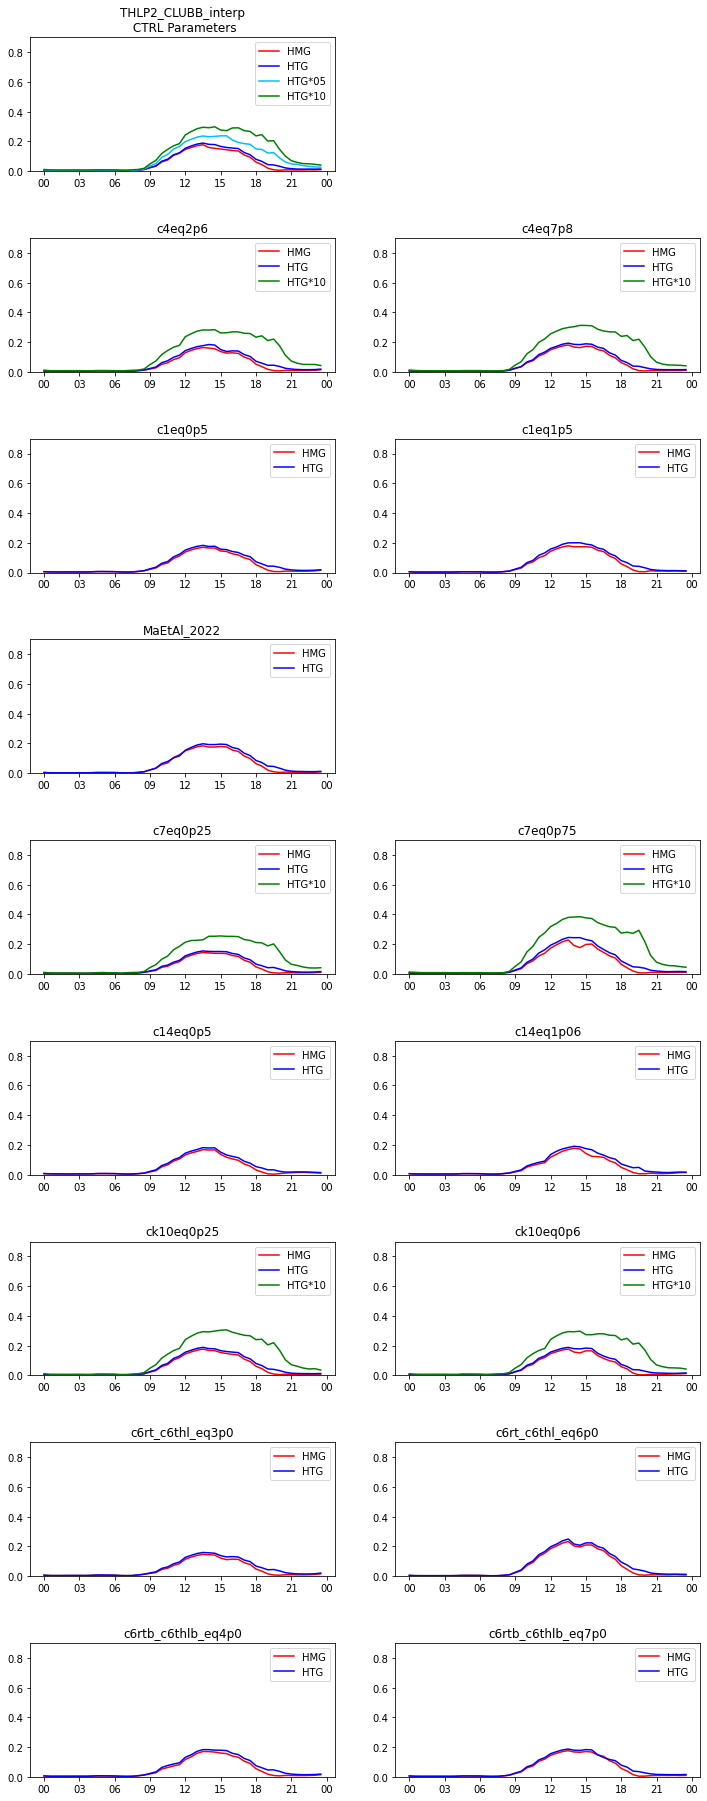

In [48]:
plot_timeseries_linePlot('THLP2_CLUBB_interp',-1, 0.0,0.9)

Matching case in HTG c4eq2p6 to HTG*10 c4eq2p6_HTG10
Matching case in HTG c4eq7p8 to HTG*10 c4eq7p8_HTG10
Matching case in HTG c7eq0p25 to HTG*10 c7eq0p25_HTG10
Matching case in HTG c7eq0p75 to HTG*10 c7eq0p75_HTG10
Matching case in HTG ck10eq0p25 to HTG*10 ck10eq0p25_HTG10
Matching case in HTG ck10eq0p6 to HTG*10 ck10eq0p6_HTG10


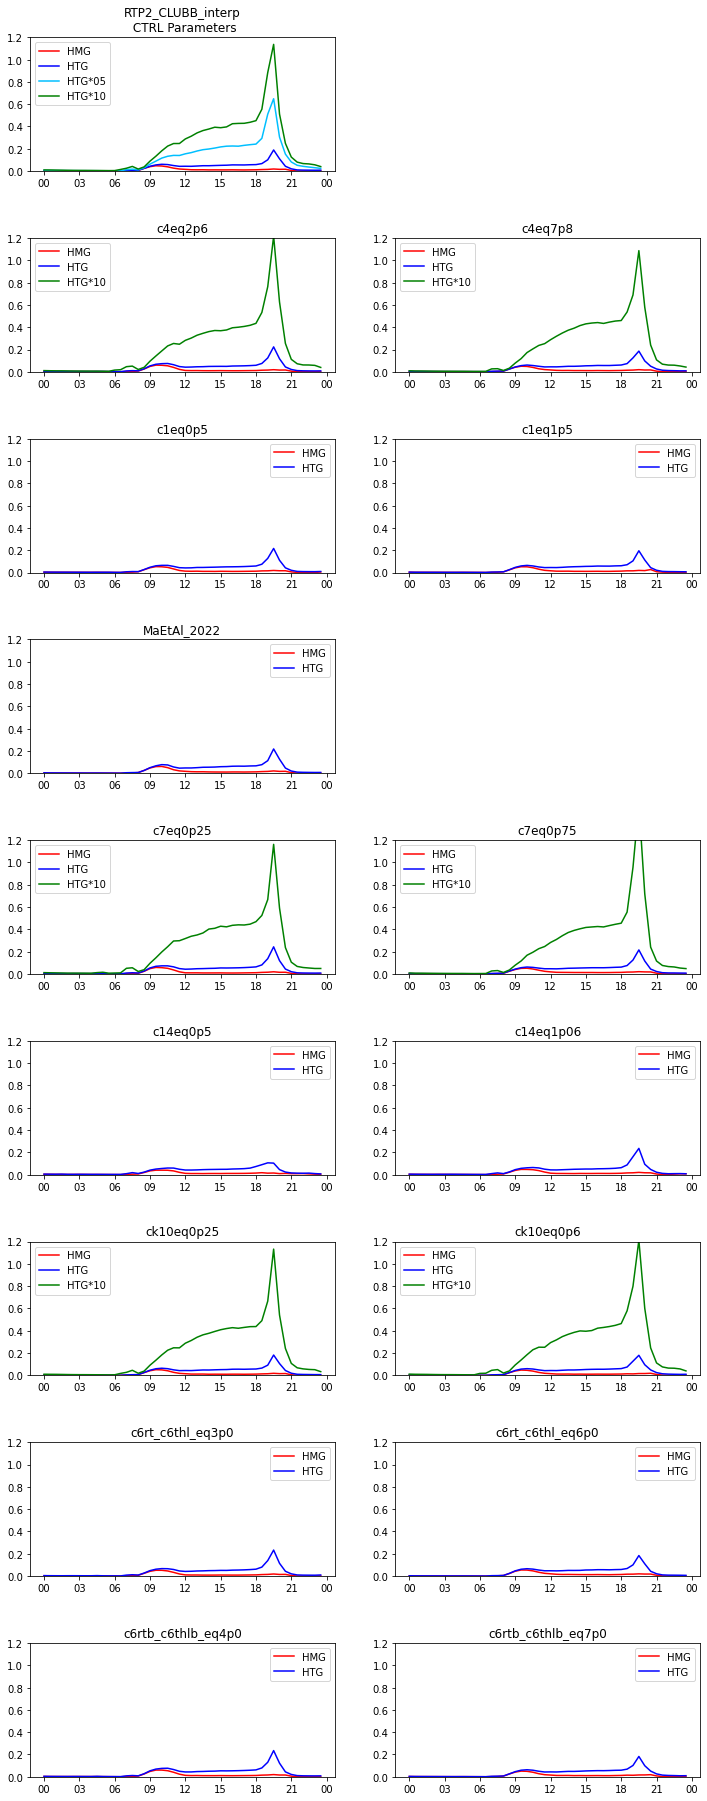

In [49]:
plot_timeseries_linePlot('RTP2_CLUBB_interp',-1, 0.0,1.2)

Matching case in HTG c4eq2p6 to HTG*10 c4eq2p6_HTG10
Matching case in HTG c4eq7p8 to HTG*10 c4eq7p8_HTG10
Matching case in HTG c7eq0p25 to HTG*10 c7eq0p25_HTG10
Matching case in HTG c7eq0p75 to HTG*10 c7eq0p75_HTG10
Matching case in HTG ck10eq0p25 to HTG*10 ck10eq0p25_HTG10
Matching case in HTG ck10eq0p6 to HTG*10 ck10eq0p6_HTG10


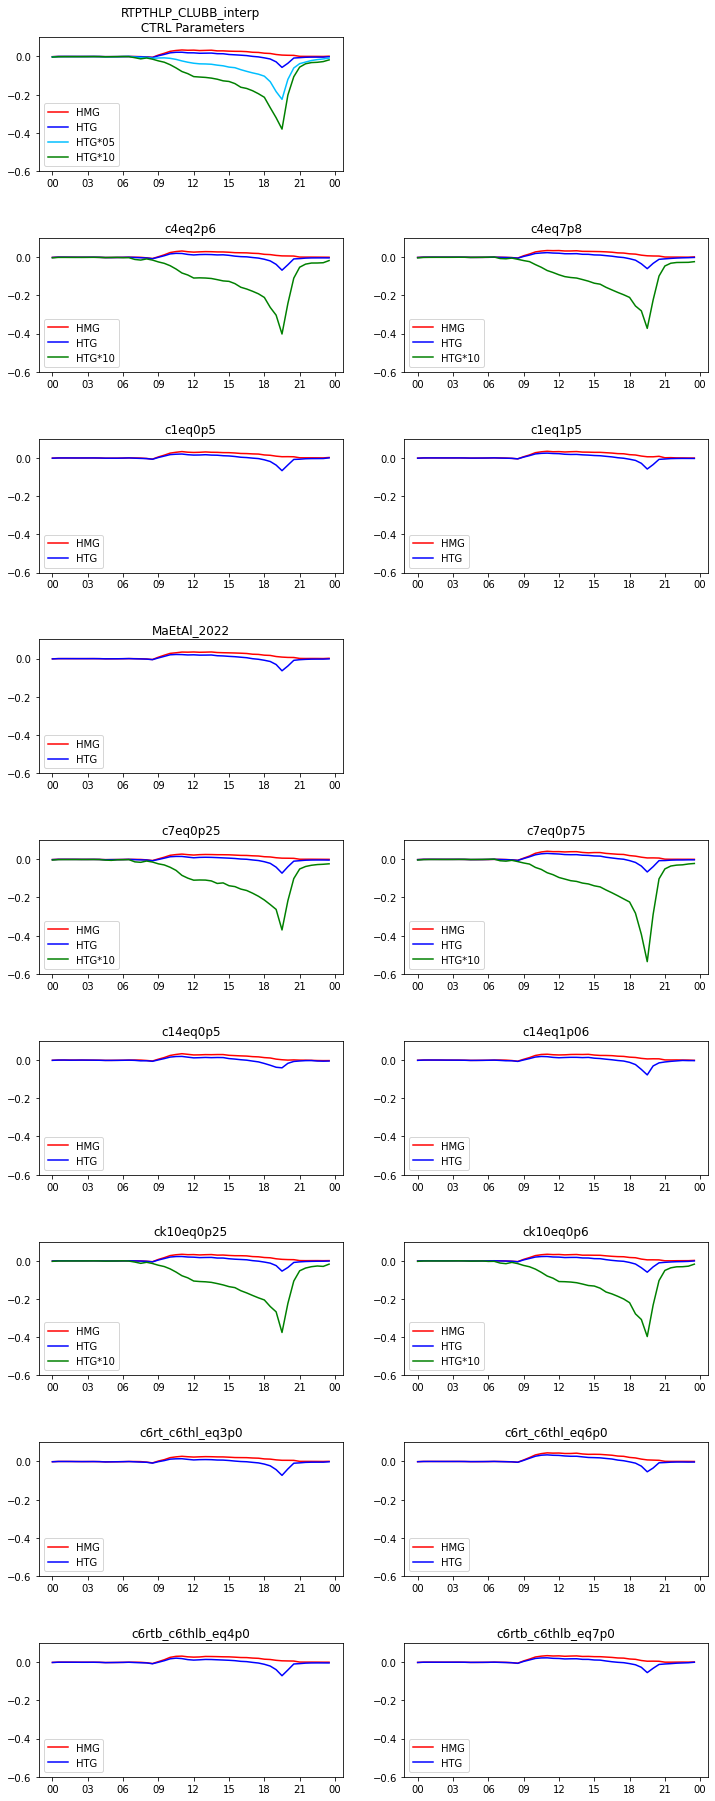

In [50]:
plot_timeseries_linePlot('RTPTHLP_CLUBB_interp',-1, -0.6,0.1)

In [51]:

# plot_timeseries_linePlotDiff('SHFLX',levSel=None)

Matching case in HTG c4eq2p6 to HTG*10 c4eq2p6_HTG10
Matching case in HTG c4eq7p8 to HTG*10 c4eq7p8_HTG10
Matching case in HTG c7eq0p25 to HTG*10 c7eq0p25_HTG10
Matching case in HTG c7eq0p75 to HTG*10 c7eq0p75_HTG10
Matching case in HTG ck10eq0p25 to HTG*10 ck10eq0p25_HTG10
Matching case in HTG ck10eq0p6 to HTG*10 ck10eq0p6_HTG10


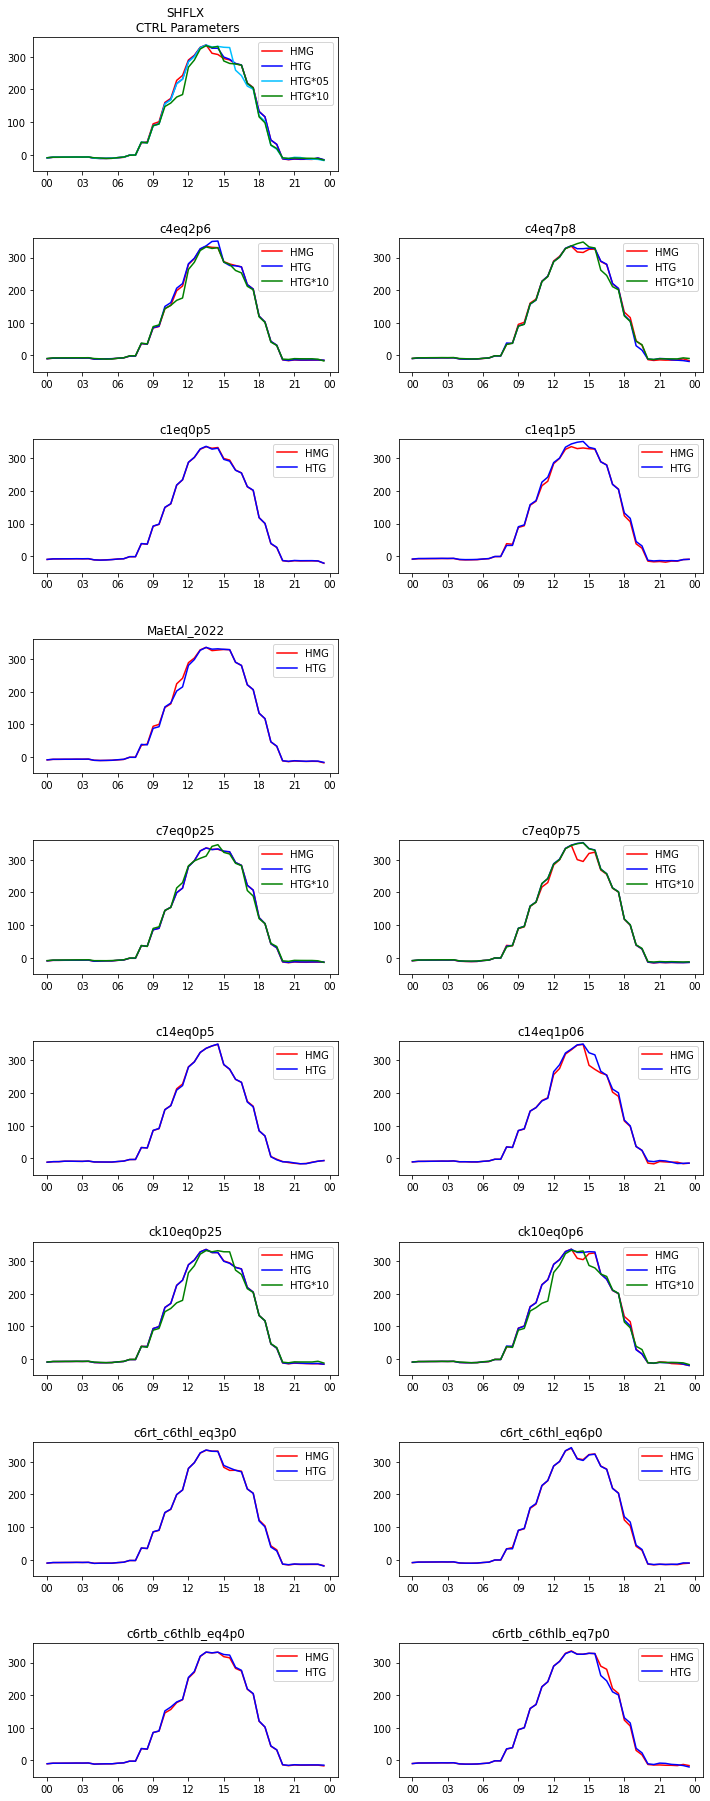

In [52]:
plot_timeseries_linePlot('SHFLX',None,-50,360)


Matching case in HTG c4eq2p6 to HTG*10 c4eq2p6_HTG10
Matching case in HTG c4eq7p8 to HTG*10 c4eq7p8_HTG10
Matching case in HTG c7eq0p25 to HTG*10 c7eq0p25_HTG10
Matching case in HTG c7eq0p75 to HTG*10 c7eq0p75_HTG10
Matching case in HTG ck10eq0p25 to HTG*10 ck10eq0p25_HTG10
Matching case in HTG ck10eq0p6 to HTG*10 ck10eq0p6_HTG10


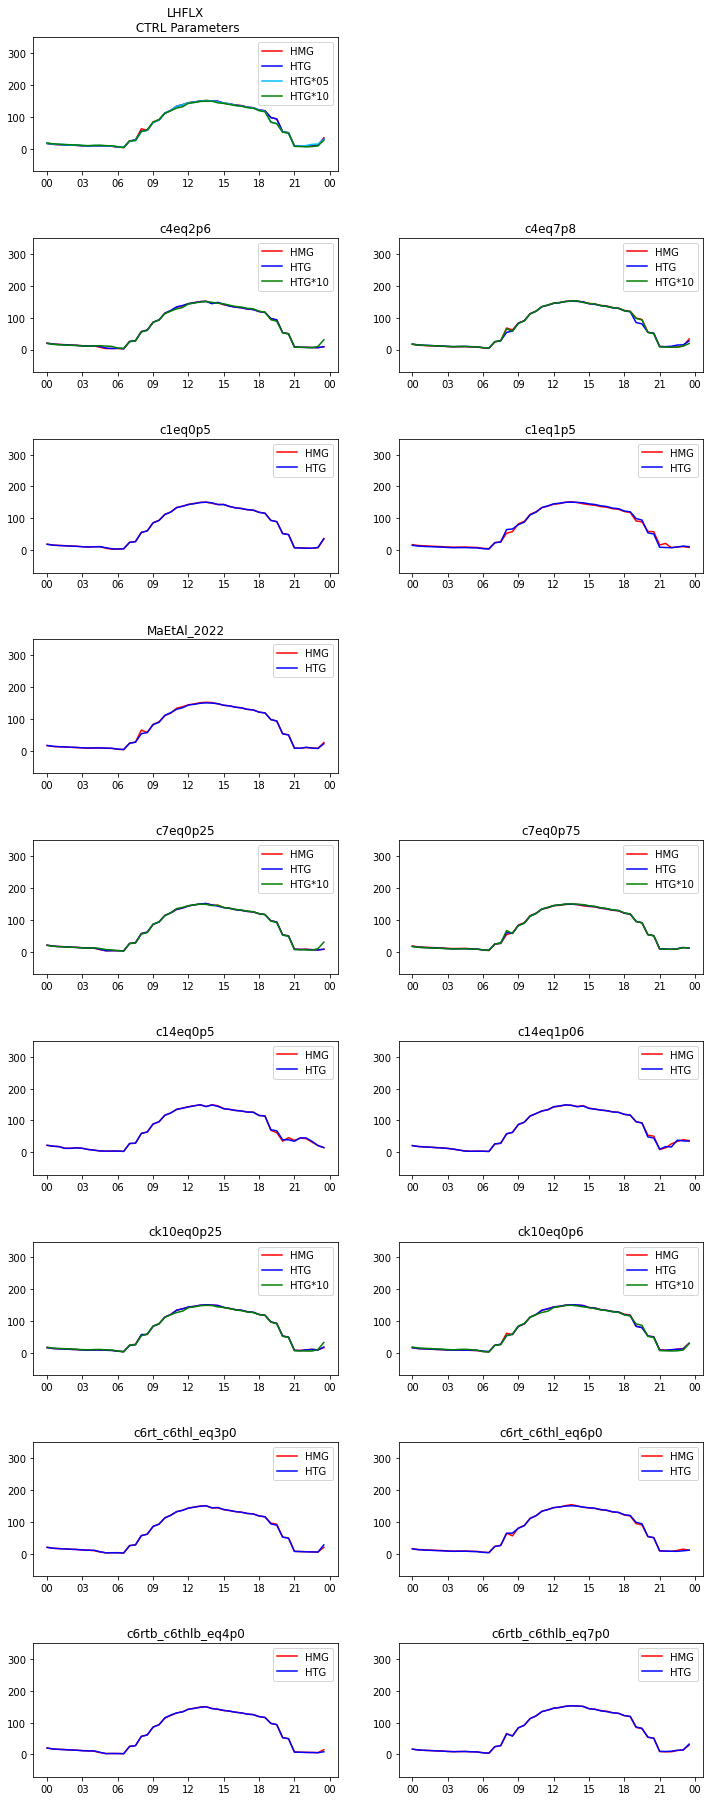

In [53]:
plot_timeseries_linePlot('LHFLX',None,-70,350)


Matching case in HTG c4eq2p6 to HTG*10 c4eq2p6_HTG10
Matching case in HTG c4eq7p8 to HTG*10 c4eq7p8_HTG10
Matching case in HTG c7eq0p25 to HTG*10 c7eq0p25_HTG10
Matching case in HTG c7eq0p75 to HTG*10 c7eq0p75_HTG10
Matching case in HTG ck10eq0p25 to HTG*10 ck10eq0p25_HTG10
Matching case in HTG ck10eq0p6 to HTG*10 ck10eq0p6_HTG10


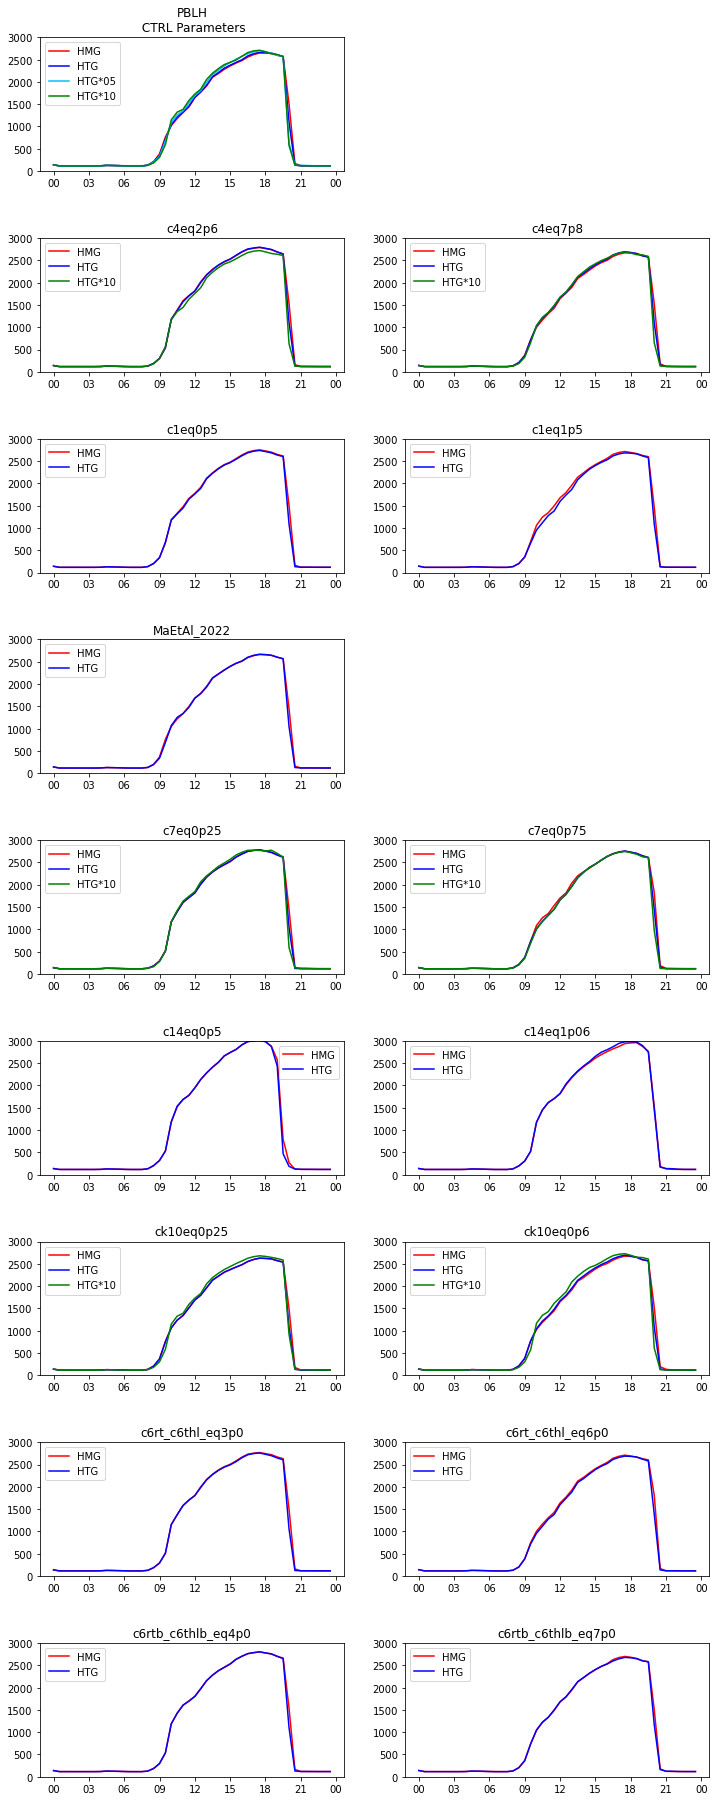

In [54]:
plot_timeseries_linePlot('PBLH',None,0,3000)

In [55]:

# plot_timeseries_linePlotDiff('TGCLDLWP',levSel=None)


Matching case in HTG c4eq2p6 to HTG*10 c4eq2p6_HTG10
Matching case in HTG c4eq7p8 to HTG*10 c4eq7p8_HTG10
Matching case in HTG c7eq0p25 to HTG*10 c7eq0p25_HTG10
Matching case in HTG c7eq0p75 to HTG*10 c7eq0p75_HTG10
Matching case in HTG ck10eq0p25 to HTG*10 ck10eq0p25_HTG10
Matching case in HTG ck10eq0p6 to HTG*10 ck10eq0p6_HTG10


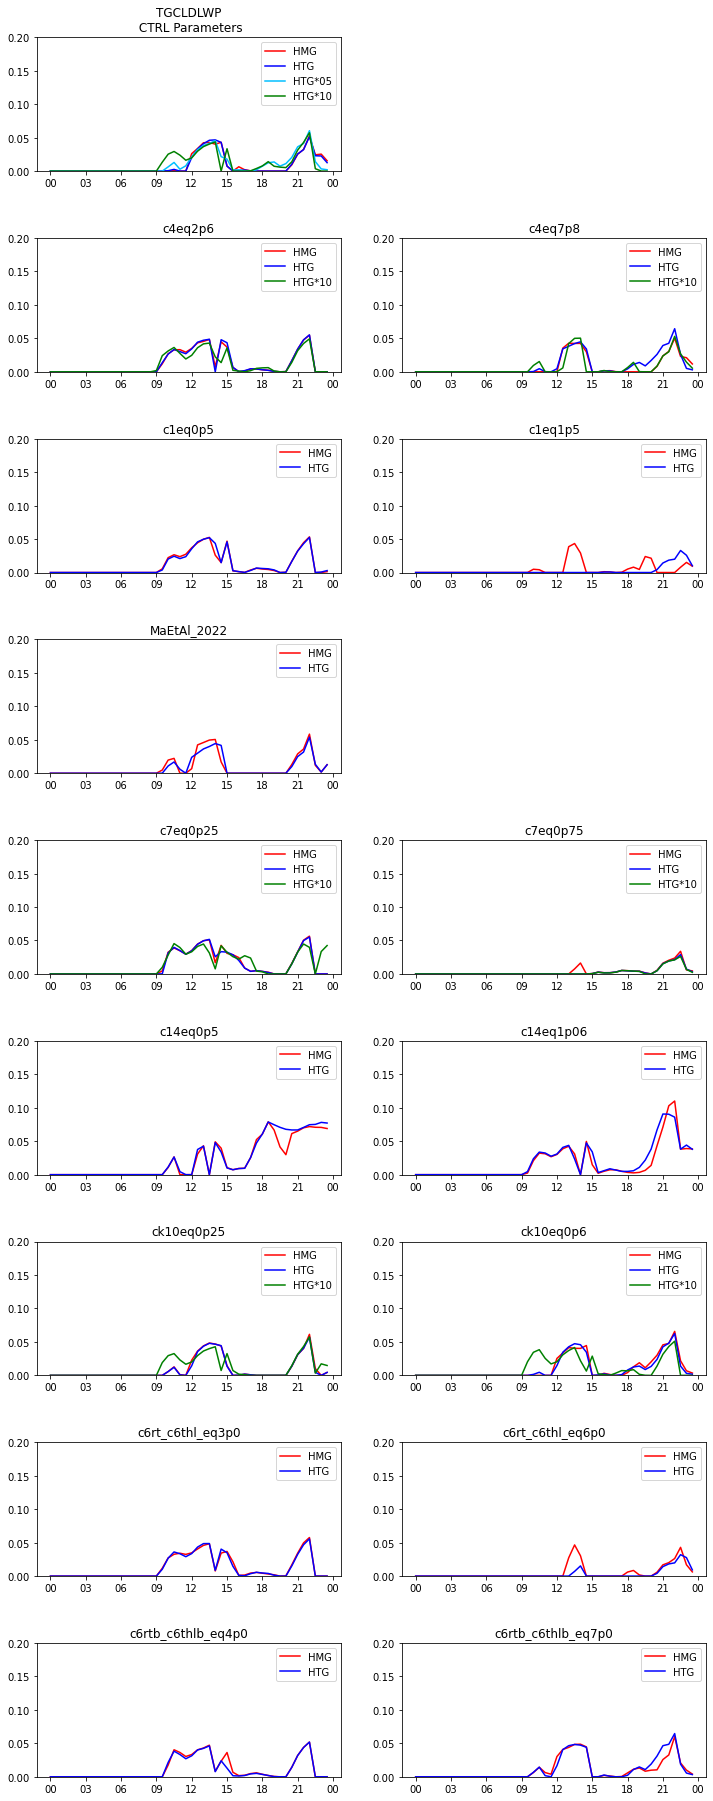

In [56]:
plot_timeseries_linePlot('TGCLDLWP',None, 0,0.2)
# plot_timeseries_linePlot('TGCLDLWP',None, 0,0.003)


Matching case in HTG c4eq2p6 to HTG*10 c4eq2p6_HTG10
Matching case in HTG c4eq7p8 to HTG*10 c4eq7p8_HTG10
Matching case in HTG c7eq0p25 to HTG*10 c7eq0p25_HTG10
Matching case in HTG c7eq0p75 to HTG*10 c7eq0p75_HTG10
Matching case in HTG ck10eq0p25 to HTG*10 ck10eq0p25_HTG10
Matching case in HTG ck10eq0p6 to HTG*10 ck10eq0p6_HTG10


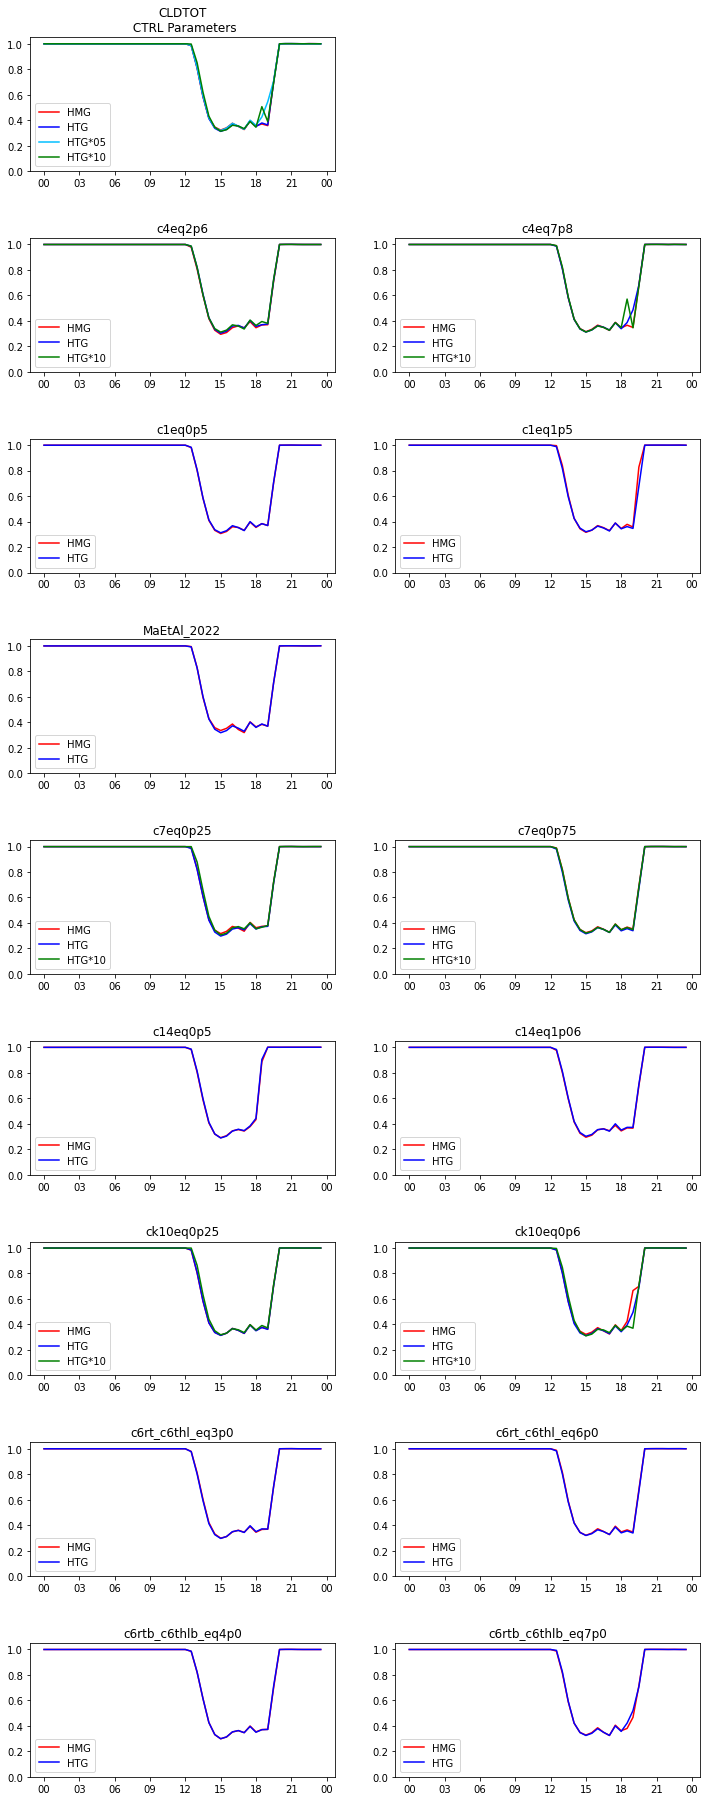

In [57]:
plot_timeseries_linePlot('CLDTOT',None, 0,1.05)

Matching case in HTG c4eq2p6 to HTG*10 c4eq2p6_HTG10
Matching case in HTG c4eq7p8 to HTG*10 c4eq7p8_HTG10
Matching case in HTG c7eq0p25 to HTG*10 c7eq0p25_HTG10
Matching case in HTG c7eq0p75 to HTG*10 c7eq0p75_HTG10
Matching case in HTG ck10eq0p25 to HTG*10 ck10eq0p25_HTG10
Matching case in HTG ck10eq0p6 to HTG*10 ck10eq0p6_HTG10


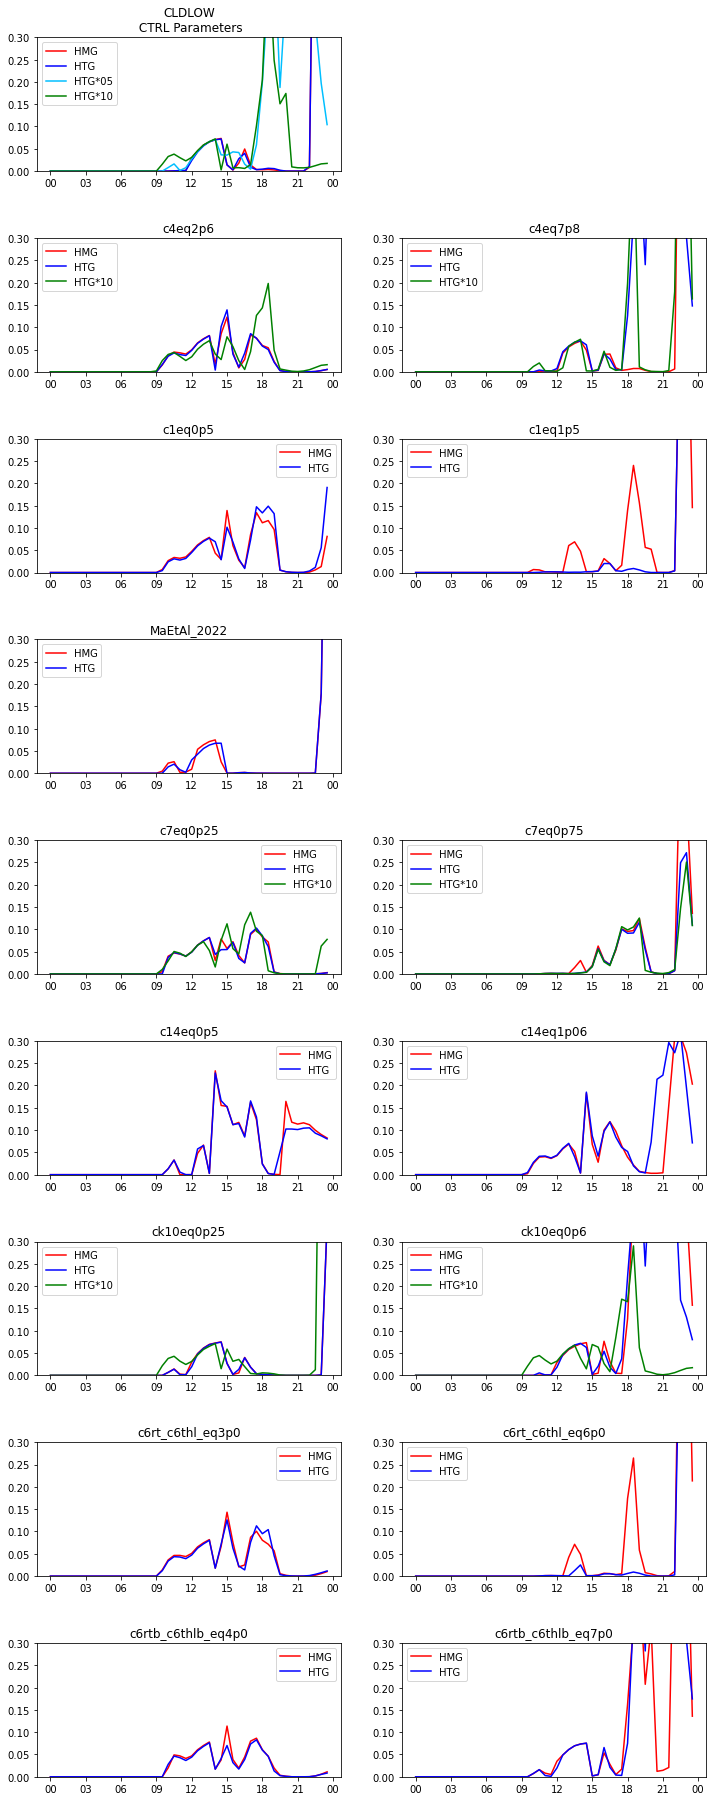

In [58]:
plot_timeseries_linePlot('CLDLOW',None, 0,0.3)

Matching case in HTG c4eq2p6 to HTG*10 c4eq2p6_HTG10
Matching case in HTG c4eq7p8 to HTG*10 c4eq7p8_HTG10
Matching case in HTG c7eq0p25 to HTG*10 c7eq0p25_HTG10
Matching case in HTG c7eq0p75 to HTG*10 c7eq0p75_HTG10
Matching case in HTG ck10eq0p25 to HTG*10 ck10eq0p25_HTG10
Matching case in HTG ck10eq0p6 to HTG*10 ck10eq0p6_HTG10


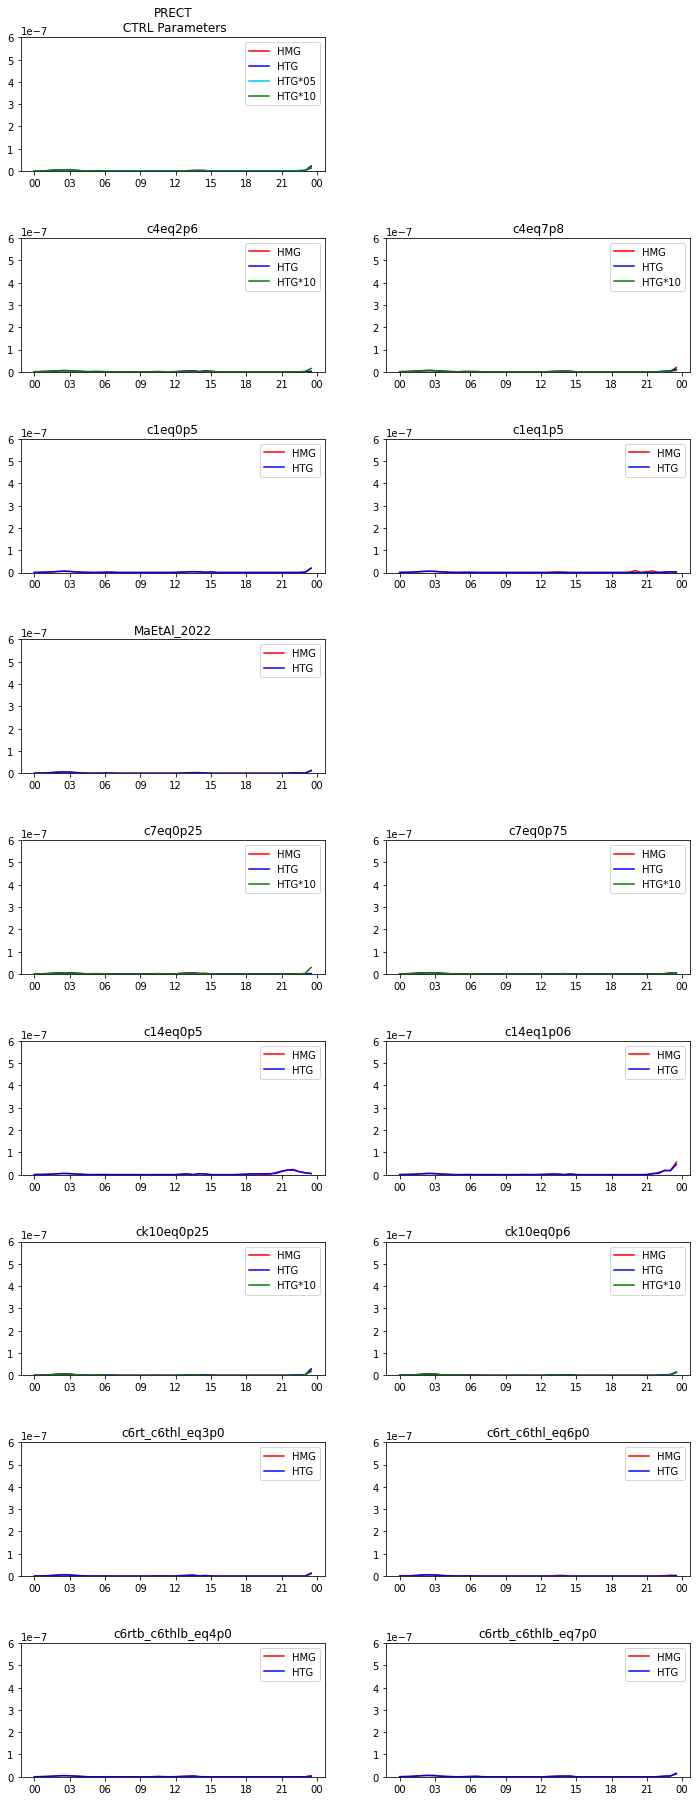

In [59]:
plot_timeseries_linePlot('PRECT',None, 0,0.6e-6)

Matching case in HTG c4eq2p6 to HTG*10 c4eq2p6_HTG10
Matching case in HTG c4eq7p8 to HTG*10 c4eq7p8_HTG10
Matching case in HTG c7eq0p25 to HTG*10 c7eq0p25_HTG10
Matching case in HTG c7eq0p75 to HTG*10 c7eq0p75_HTG10
Matching case in HTG ck10eq0p25 to HTG*10 ck10eq0p25_HTG10
Matching case in HTG ck10eq0p6 to HTG*10 ck10eq0p6_HTG10


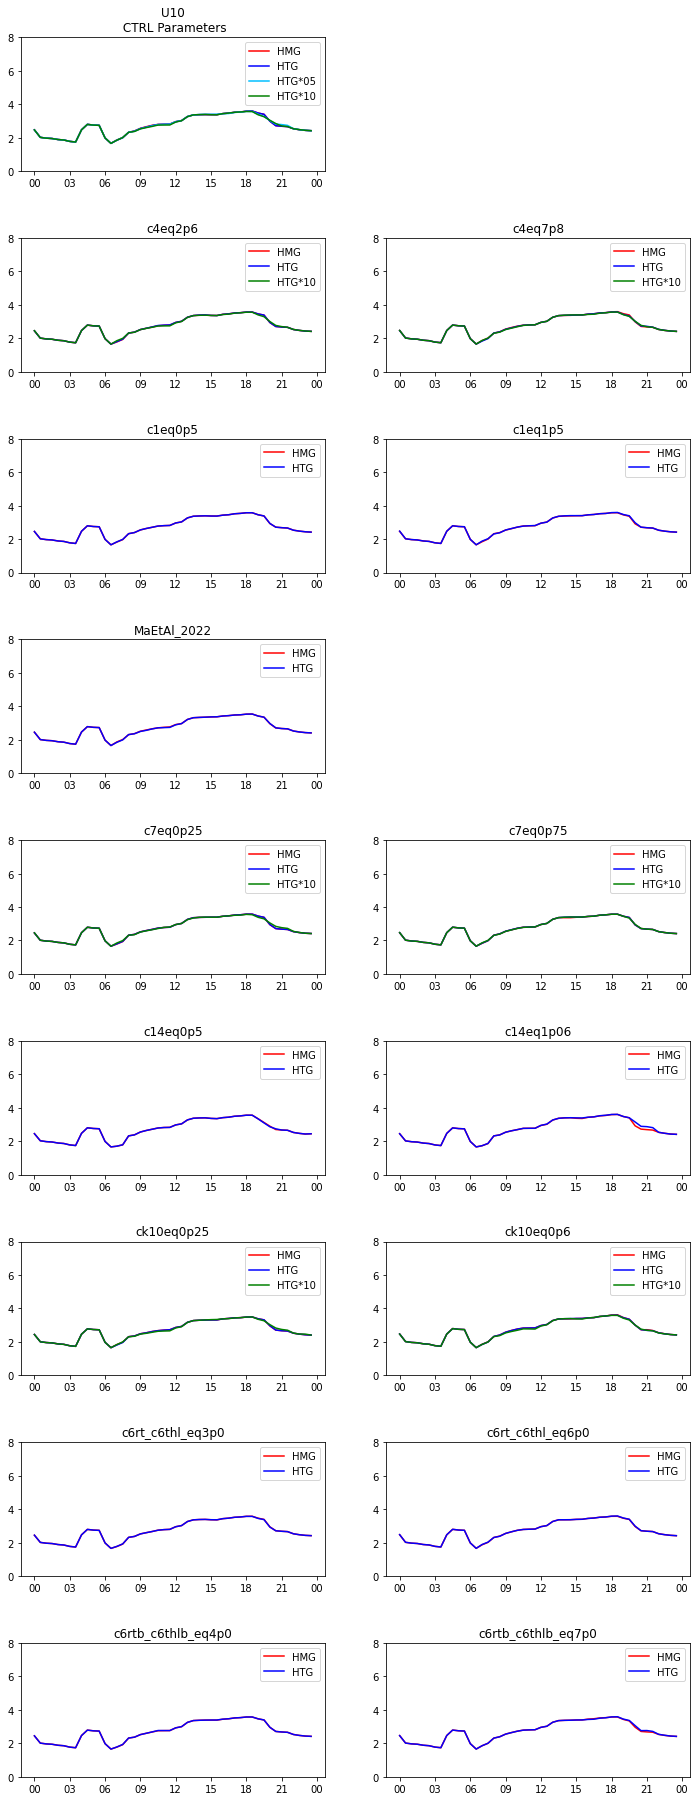

In [60]:
plot_timeseries_linePlot('U10',None,0,8)

## Time-Height plots

In [27]:
def plotTimeHeight_diffs(varPlot,levMax, levsDiff): 
        
    from matplotlib.dates import DateFormatter
    
    ## Figure out how high plots should go 
    iLevs = np.where(hmg_all.levInterp.values>=levMax)[0]
    
    hmg_allSel = hmg_all.isel(levInterp=iLevs)
    htg_allSel = htg_all.isel(levInterp=iLevs) 
    
    
    ## Set up figure... 
    fig,axs = plt.subplots(len(casePairNames)+1,2, figsize=(12,2*len(caseNames)))
    fig.subplots_adjust(hspace=0.5)

    gs = axs[0, 1].get_gridspec()
    # remove the underlying axes
    for ax in axs[0, 0:]:
        ax.remove()
    axbig = fig.add_subplot(gs[0, 0:])

    axs     = axs.ravel()
    
    ## Plot control case first (large upper plot):
    axbig.contourf(hmg_allSel.time.values, hmg_allSel.levInterp.values, 
                   np.squeeze(htg_allSel.sel(case='ctrl')[varPlot].values -
                              hmg_allSel.sel(case='ctrl')[varPlot].values).transpose(),
                   levsDiff, cmap='bwr', extend='both')
    axbig.set_title(varPlot+' (HTG-HMG)\nCTRL Parameters')
    axbig.invert_yaxis()
    axbig.set_ylim([980,levMax])

    
    casePlot = 2
        
    for iCase in range(len(casePairNames)): 
        matchCases = [i for i in caseNames if i.startswith(casePairNames[iCase])]
        
        for iSel in range(len(matchCases)):     
            cplot = axs[casePlot].contourf(hmg_allSel.time.values,  hmg_allSel.levInterp.values,
                    np.squeeze(htg_allSel.sel(case=matchCases[iSel])[varPlot].values -
                               hmg_allSel.sel(case=matchCases[iSel])[varPlot].values).transpose(),
                    levsDiff, cmap='bwr',extend='both')
            axs[casePlot].set_title(matchCases[iSel])
            axs[casePlot].invert_yaxis()
            axs[casePlot].set_ylim([980,levMax])
            axs[casePlot].xaxis.set_major_formatter(DateFormatter("%H"))
            
            ## Add colorbar to last plot  
            if ((iCase==len(casePairNames)-1) & (iSel==0)): 
                ax_position = axs[casePlot].get_position()
                cbar_ax = fig.add_axes([ax_position.x0+0.1, ax_position.y0-0.03, ax_position.width+0.2, 0.01])
                cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
                tick_locator = ticker.MaxNLocator(nbins=5)
                cbar.locator = tick_locator
                cbar.update_ticks()
                cbar.ax.tick_params(labelsize=12)
                               
            if len(matchCases)==1:
                fig.delaxes(axs[casePlot+1])
                casePlot = casePlot+2
            else: 
                casePlot = casePlot+1
    
    return 

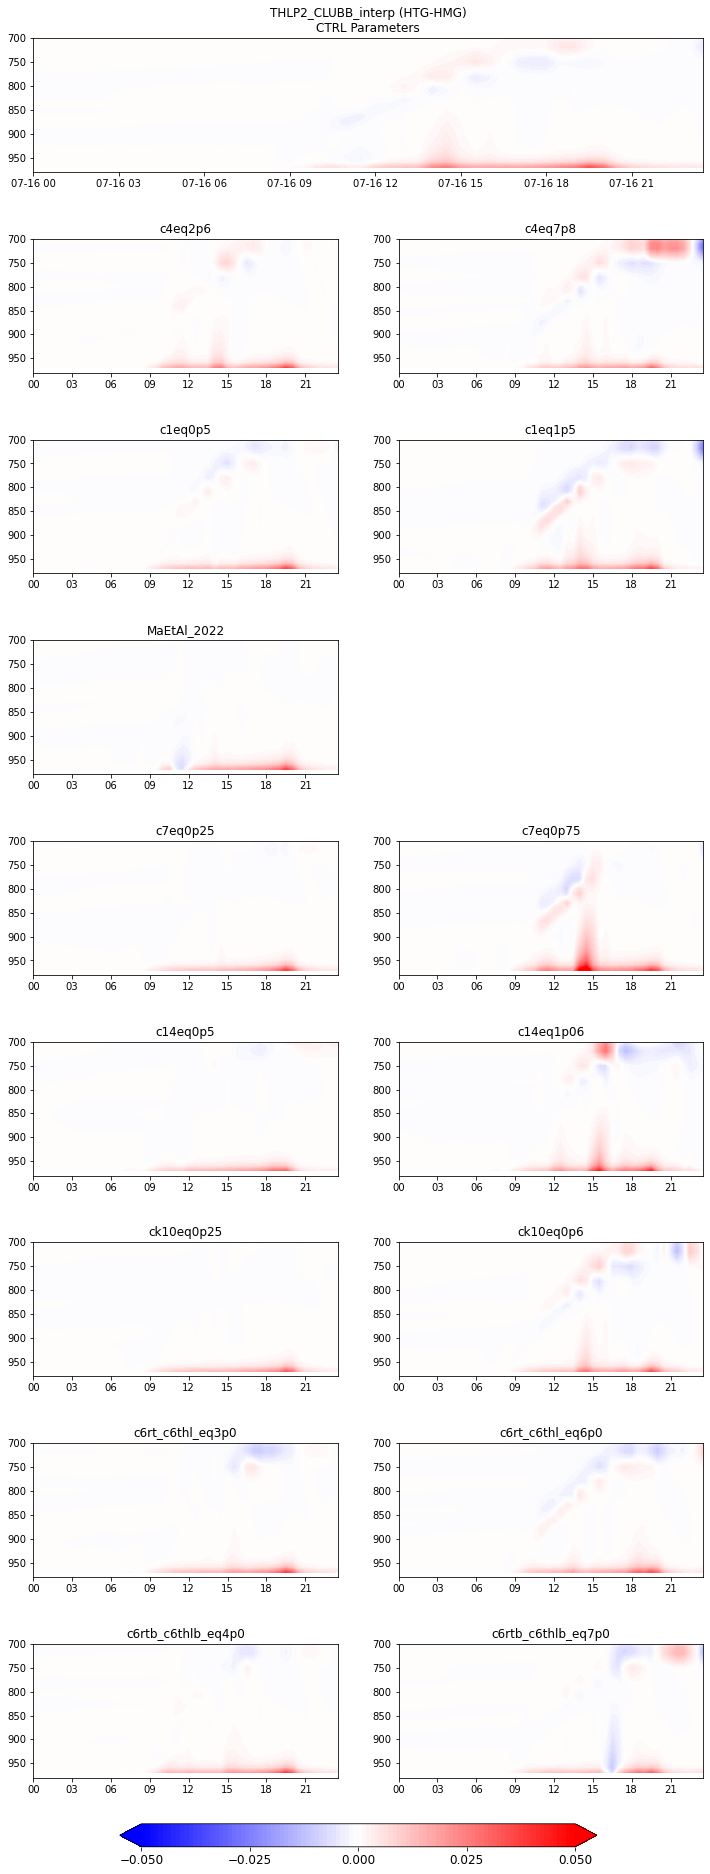

In [28]:
# plotTimeHeight_diffs('THLP2_CLUBB_interp',700, np.arange(-0.1,0.105,0.005))  #06/??
plotTimeHeight_diffs('THLP2_CLUBB_interp',700, np.arange(-0.05,0.051,0.001))  #09/23


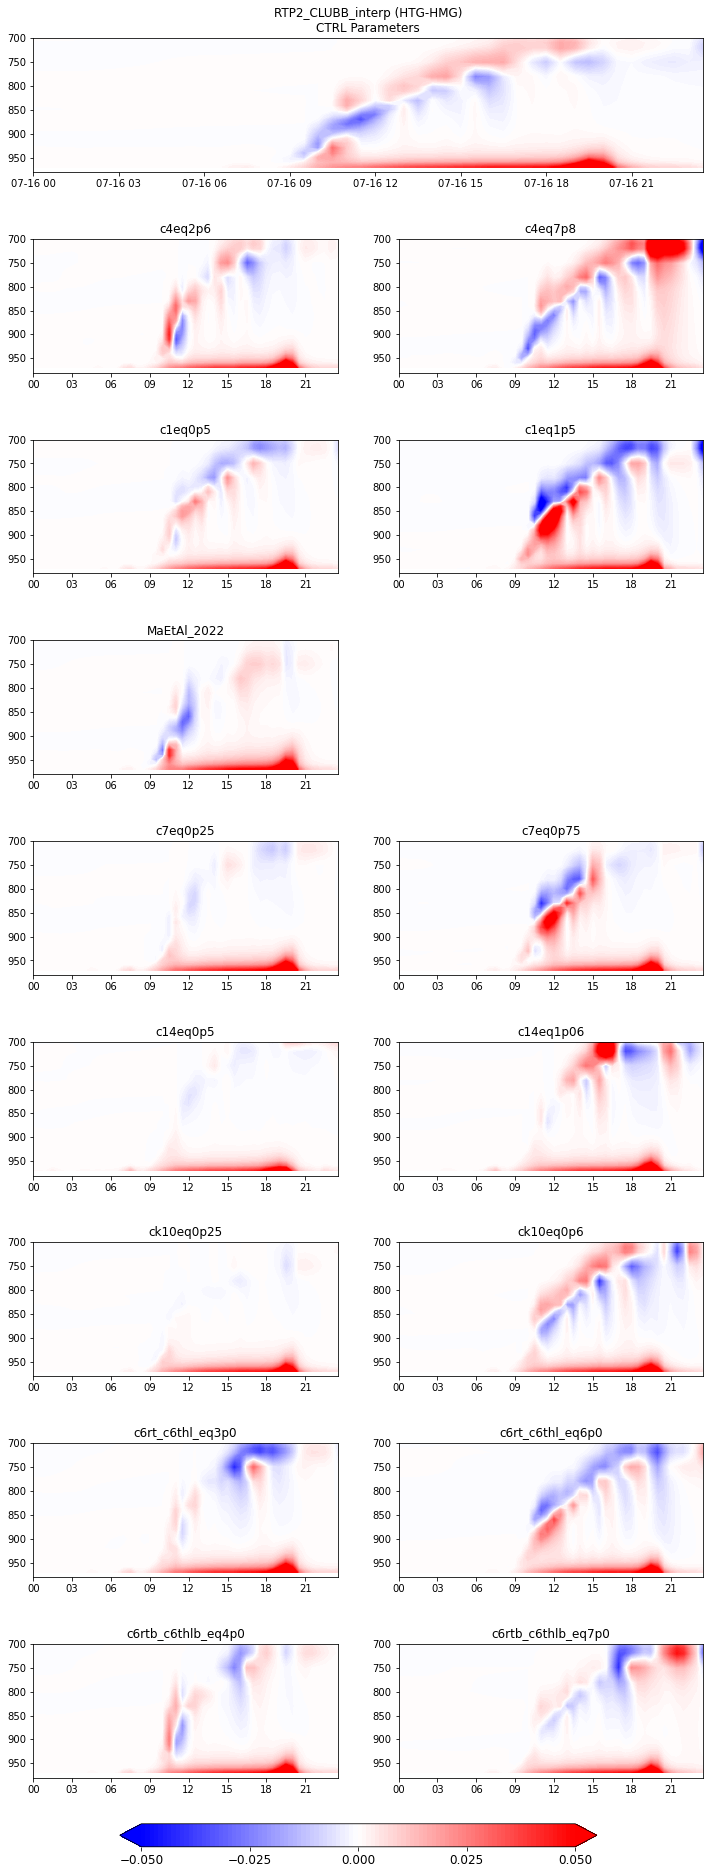

In [29]:
# plotTimeHeight_diffs('RTP2_CLUBB_interp',700, np.arange(-0.16,0.165,0.005))
plotTimeHeight_diffs('RTP2_CLUBB_interp',700, np.arange(-0.05,0.051,0.001))


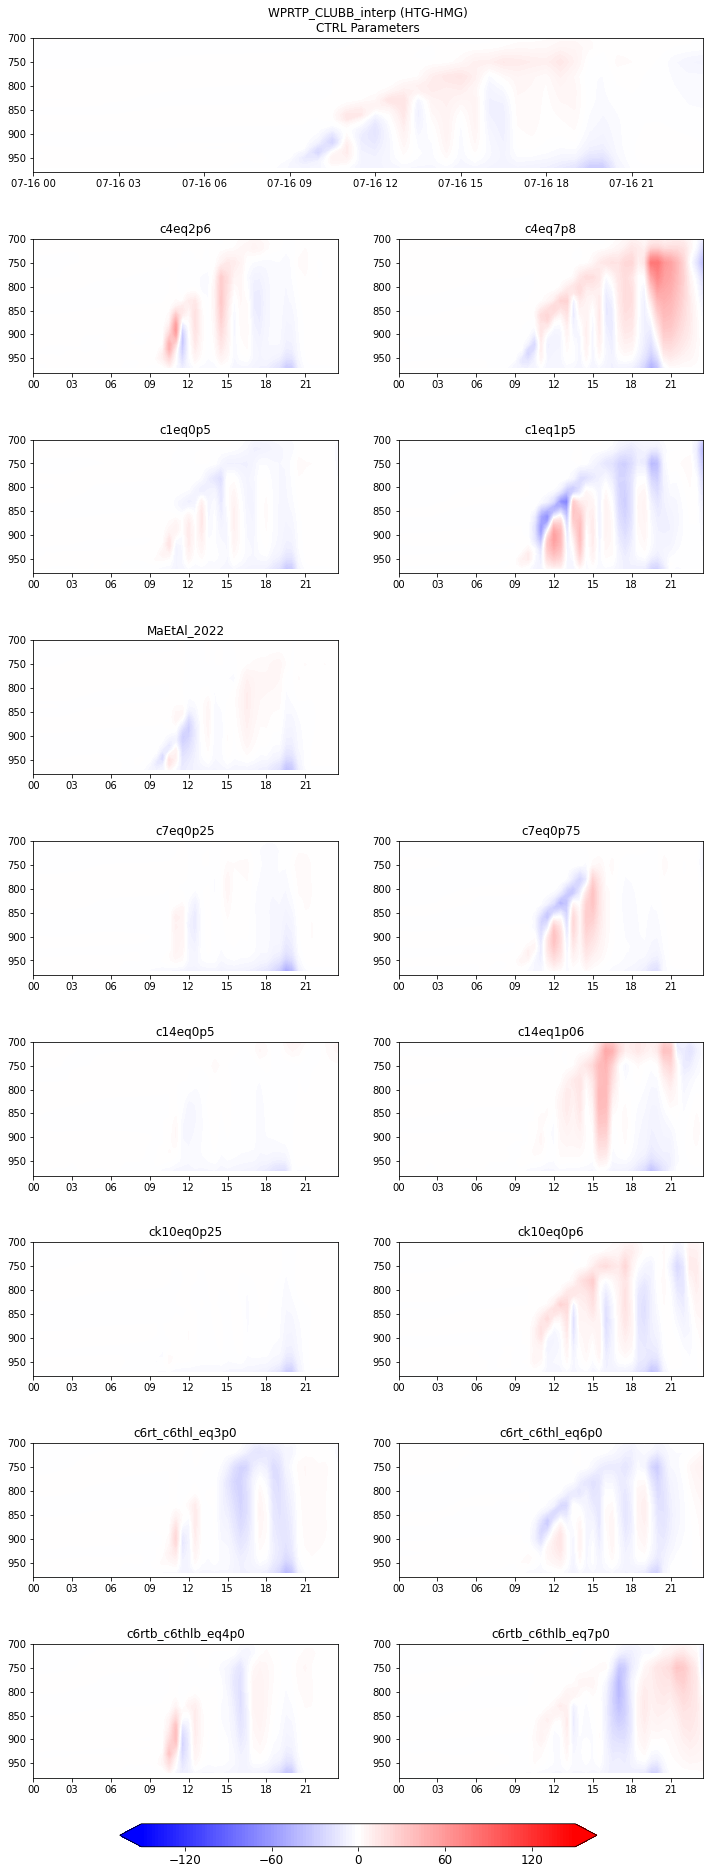

In [30]:
plotTimeHeight_diffs('WPRTP_CLUBB_interp',700, np.arange(-150,152,2))

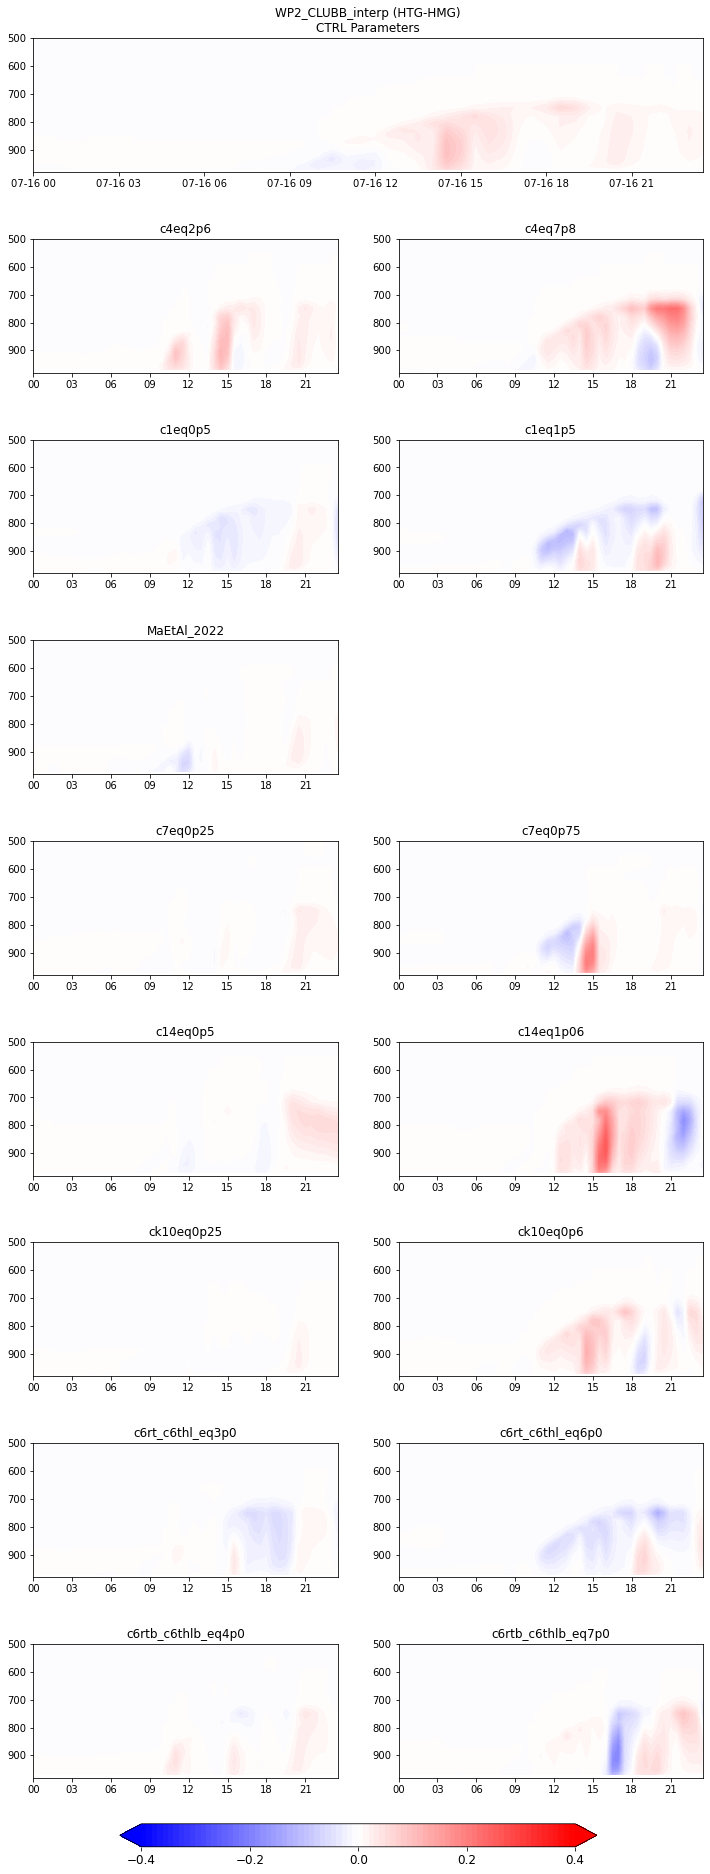

In [31]:
# plotTimeHeight_diffs('WP2_CLUBB_interp',700, np.arange(-0.6,0.605,0.005))
plotTimeHeight_diffs('WP2_CLUBB_interp',500, np.arange(-0.4,0.41,0.01))


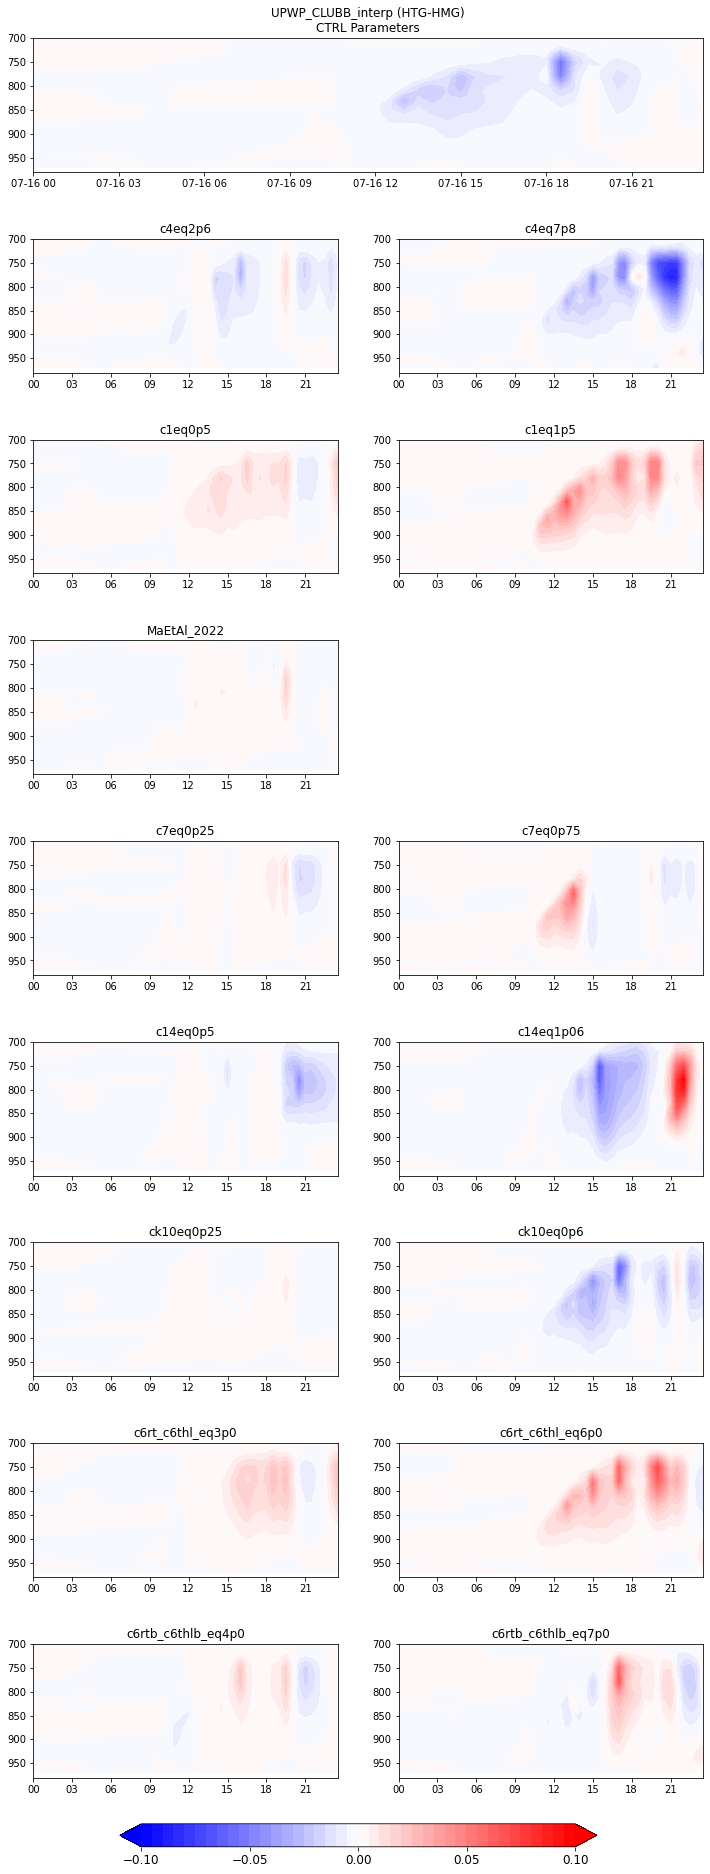

In [32]:
plotTimeHeight_diffs('UPWP_CLUBB_interp',700, np.arange(-0.1,0.105,0.005))

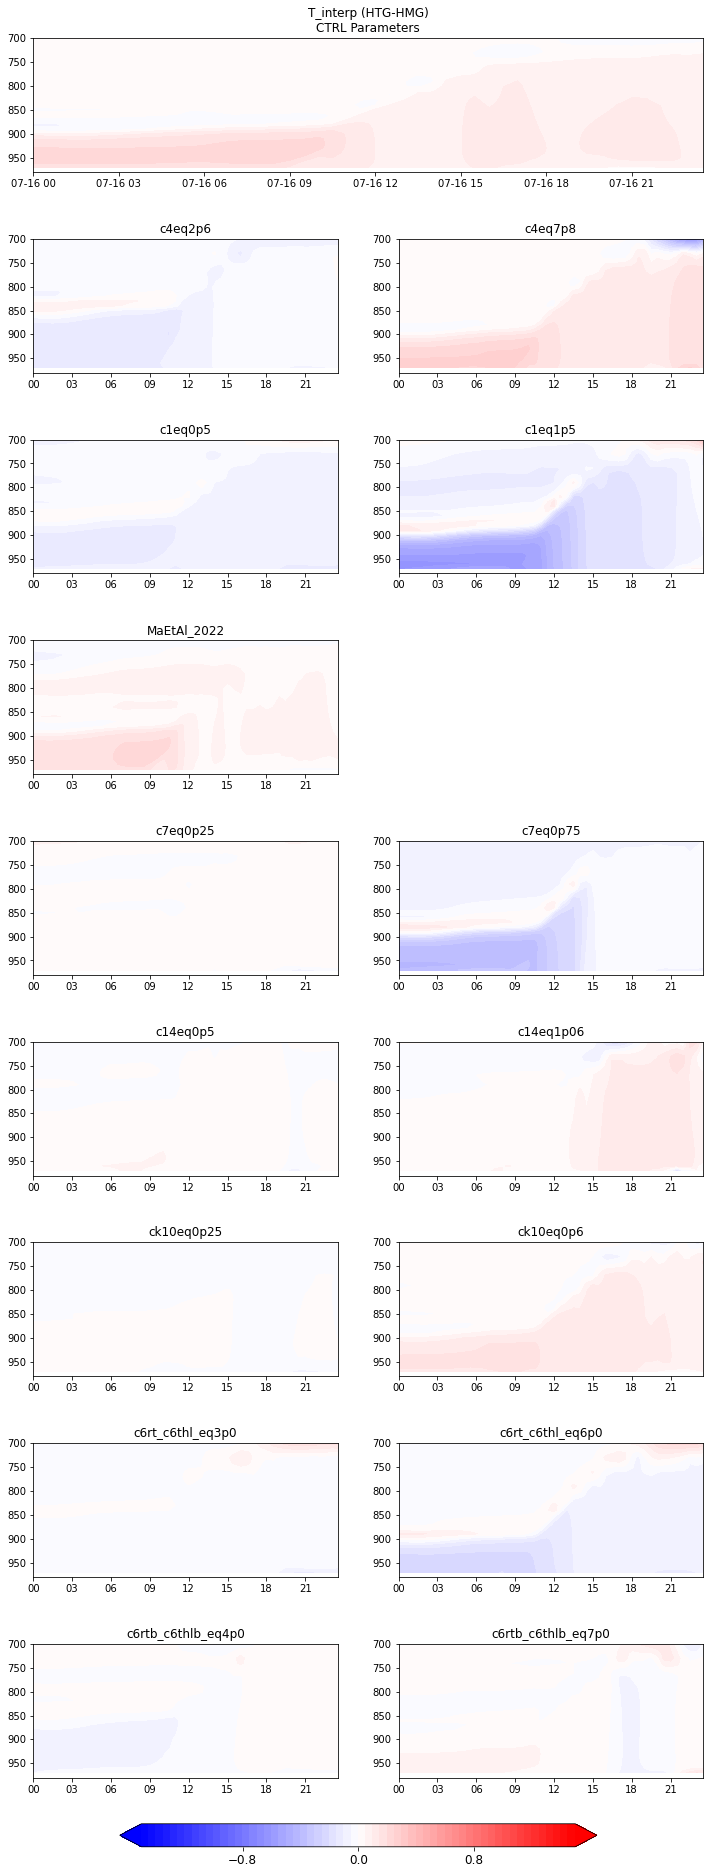

In [33]:
plotTimeHeight_diffs('T_interp',700, np.arange(-1.5, 1.55, 0.05))

### Plot mean profile 

In [37]:
def plot_profile(varPlot,startHr,endHr,minX,maxX,botLev,topLev):
    
    
    ## Select appropriate data 
    if np.shape(hmg_all[varPlot].values)[2]==len(hmg_all.ilev.values):
        levSel = 'ilev'
    elif np.shape(hmg_all[varPlot].values)[2]==len(hmg_all.lev.values):
        levSel = 'lev'
    elif np.shape(hmg_all[varPlot].values)[2]==len(hmg_all.levInterp.values):
        levSel = 'levInterp'
        
                            
    ## First, get means (& std) over the selected hours and ens cases
    iTimeSel = np.where((hmg_all["time.hour"].values>=startHr) & 
                        (hmg_all["time.hour"].values<=endHr))[0]

    
    hmgAll_TimeSel     = hmg_all.isel(time=iTimeSel).mean(dim=["time"])
    htgAll_TimeSel     = htg_all.isel(time=iTimeSel).mean(dim=["time"])
    multAll_TimeSel    = mult_all.isel(time=iTimeSel).mean(dim=["time"])
    # vertResAll_TimeSel = vertRes_all.isel(time=iTimeSel).mean(dim=["time"])
    
    
    
    ## Set up figure... 
    fig,axs = plt.subplots(len(casePairNames)+1,2, figsize=(10,3*len(caseNames)))
    fig.subplots_adjust(hspace=0.5)
    axs     = axs.ravel()
    

    axs[0].plot(np.squeeze(hmgAll_TimeSel.sel(case='ctrl')[varPlot].values), hmgAll_TimeSel[levSel].values, 'r-', label='HMG')
    axs[0].plot(np.squeeze(htgAll_TimeSel.sel(case='ctrl')[varPlot].values), htgAll_TimeSel[levSel].values, 'b-', label='HTG')
    axs[0].plot(np.squeeze(multAll_TimeSel.sel(case='HTG*05')[varPlot].values), multAll_TimeSel[levSel].values, color='deepskyblue', label='HTG*05')
    axs[0].plot(np.squeeze(multAll_TimeSel.sel(case='HTG*10')[varPlot].values), multAll_TimeSel[levSel].values, color='g', label='HTG*10')

    axs[0].legend()
    axs[0].set_title(varPlot+' (hrs '+str(startHr)+'-'+str(endHr)+')\n CTRL Parameters')
    axs[0].set_xlim([minX,maxX])
    axs[0].invert_yaxis()
    axs[0].set_ylim([botLev, topLev])
    fig.delaxes(axs[1])
    
#     ## Plot different vertical resolution control cases 
#     axs[1].plot(np.squeeze(hmgAll_TimeSel.sel(case='ctrl')[varPlot].values), hmgAll_TimeSel[levSel].values, 'r-', label='HMG_64L')
#     axs[1].plot(np.squeeze(htgAll_TimeSel.sel(case='ctrl')[varPlot].values), htgAll_TimeSel[levSel].values, 'b-', label='HTG_64L')
#     axs[1].plot(np.squeeze(vertResAll_TimeSel.sel(case='HMG_58L')[varPlot].values), vertResAll_TimeSel[levSel].values, '--',color='firebrick',  label='HMG_58L')
#     axs[1].plot(np.squeeze(vertResAll_TimeSel.sel(case='HTG_58L')[varPlot].values), vertResAll_TimeSel[levSel].values, '--',color='cornflowerblue', label='HTG_58L')
#     axs[1].plot(np.squeeze(vertResAll_TimeSel.sel(case='HMG_32L')[varPlot].values), vertResAll_TimeSel[levSel].values, ':',color='coral', label='HMG_32L')
#     axs[1].plot(np.squeeze(vertResAll_TimeSel.sel(case='HTG_32L')[varPlot].values), vertResAll_TimeSel[levSel].values, ':',color='deepskyblue', label='HTG_32L')
       
#     axs[1].legend()
#     axs[1].set_title(varPlot+' (hrs '+str(startHr)+'-'+str(endHr)+')\n CTRL Parameters (vertRes)')
#     axs[1].set_xlim([minX,maxX])
#     axs[1].invert_yaxis()
#     axs[1].set_ylim([botLev, topLev])
    
    
    casePlot = 2
        
    for iCase in range(len(casePairNames)): 
        matchCases      = [i for i in caseNames if i.startswith(casePairNames[iCase])]
    
        # matchCases_mult = [i for i in caseNames_multClubb if i.startswith(casePairNames[iCase])]
        matchCases_mult = []
        
        for iSel in range(len(matchCases)):        


            axs[casePlot].plot(np.squeeze(hmgAll_TimeSel.sel(case=matchCases[iSel])[varPlot].values), 
                               hmgAll_TimeSel[levSel].values, 'r-', label='HMG')
            axs[casePlot].plot(np.squeeze(htgAll_TimeSel.sel(case=matchCases[iSel])[varPlot].values),
                               htgAll_TimeSel[levSel].values, 'b-', label='HTG')

            ## Add multiplier? 
            if len(matchCases_mult)>0:
                axs[casePlot].plot(mult_clubb.time.values, 
                               np.squeeze(mult_clubb[varPlot].sel(case=matchCases_mult[iSel]).isel(levInterp=levSel)),
                               'g',label='HTG*10')
                print('Matching case in HTG %s to HTG*10 %s' % (matchCases[iSel], matchCases_mult[iSel]) )
                 
            axs[casePlot].legend()
            axs[casePlot].set_title(matchCases[iSel])
            # axs[casePlot].xaxis.set_major_formatter(DateFormatter("%H"))
            axs[casePlot].set_xlim([minX,maxX])
            axs[casePlot].invert_yaxis()
            axs[casePlot].set_ylim([botLev, topLev])
    
            
            if len(matchCases)==1:
                fig.delaxes(axs[casePlot+1])
                casePlot = casePlot+2
            else: 
                casePlot = casePlot+1

    
    return 


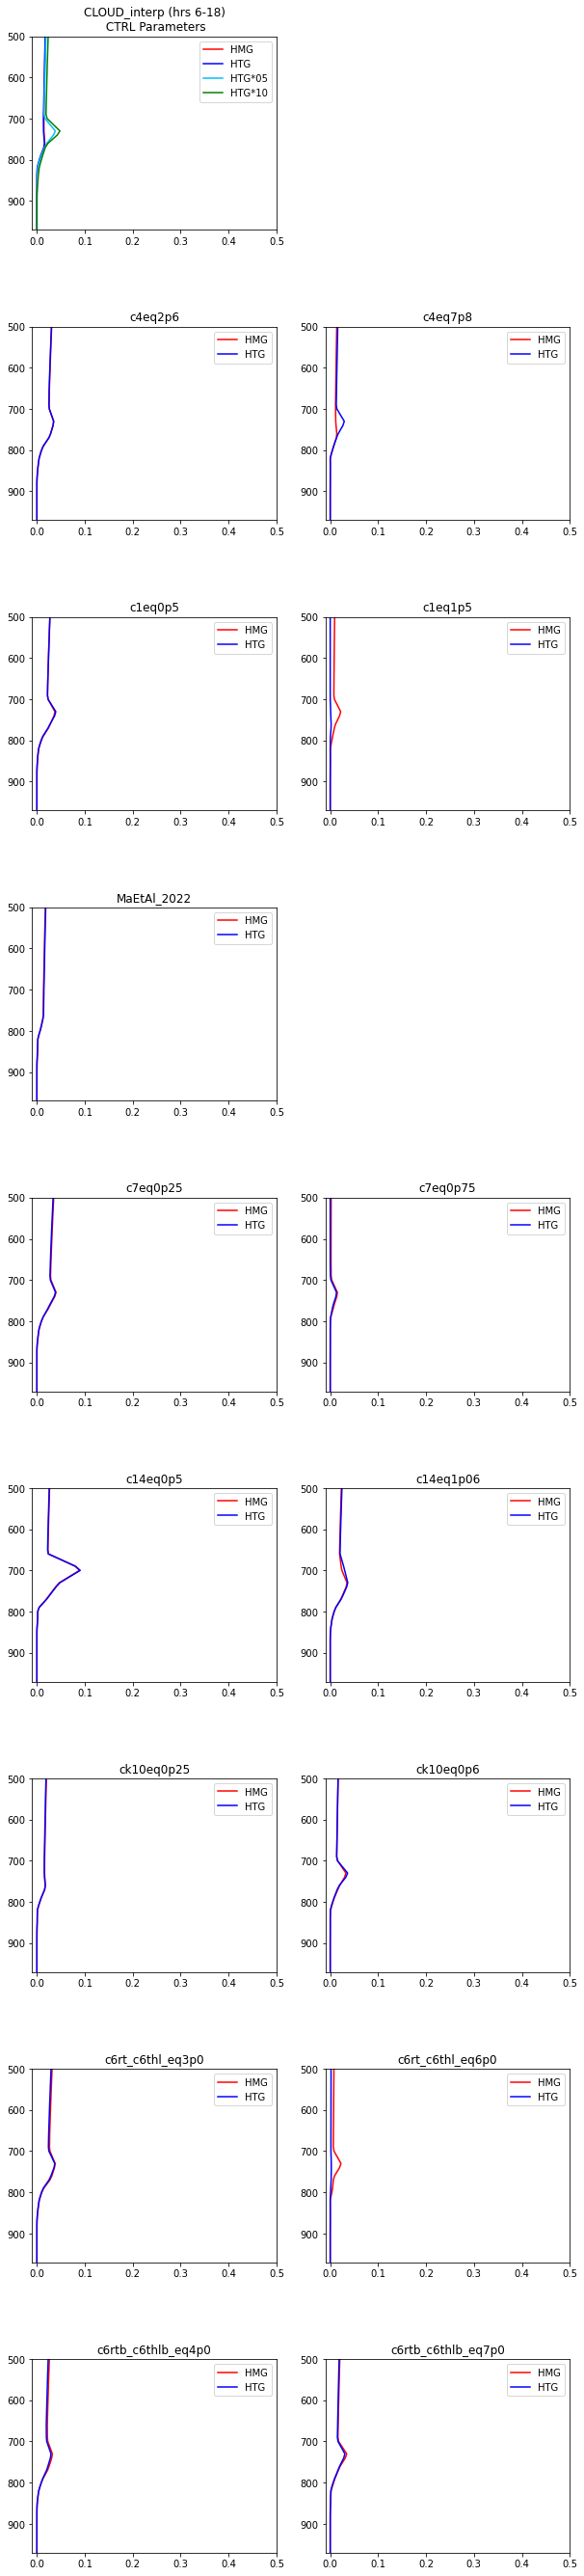

In [40]:
plot_profile('CLOUD_interp',6,18,
                         -0.01,0.5,
                         970,500)



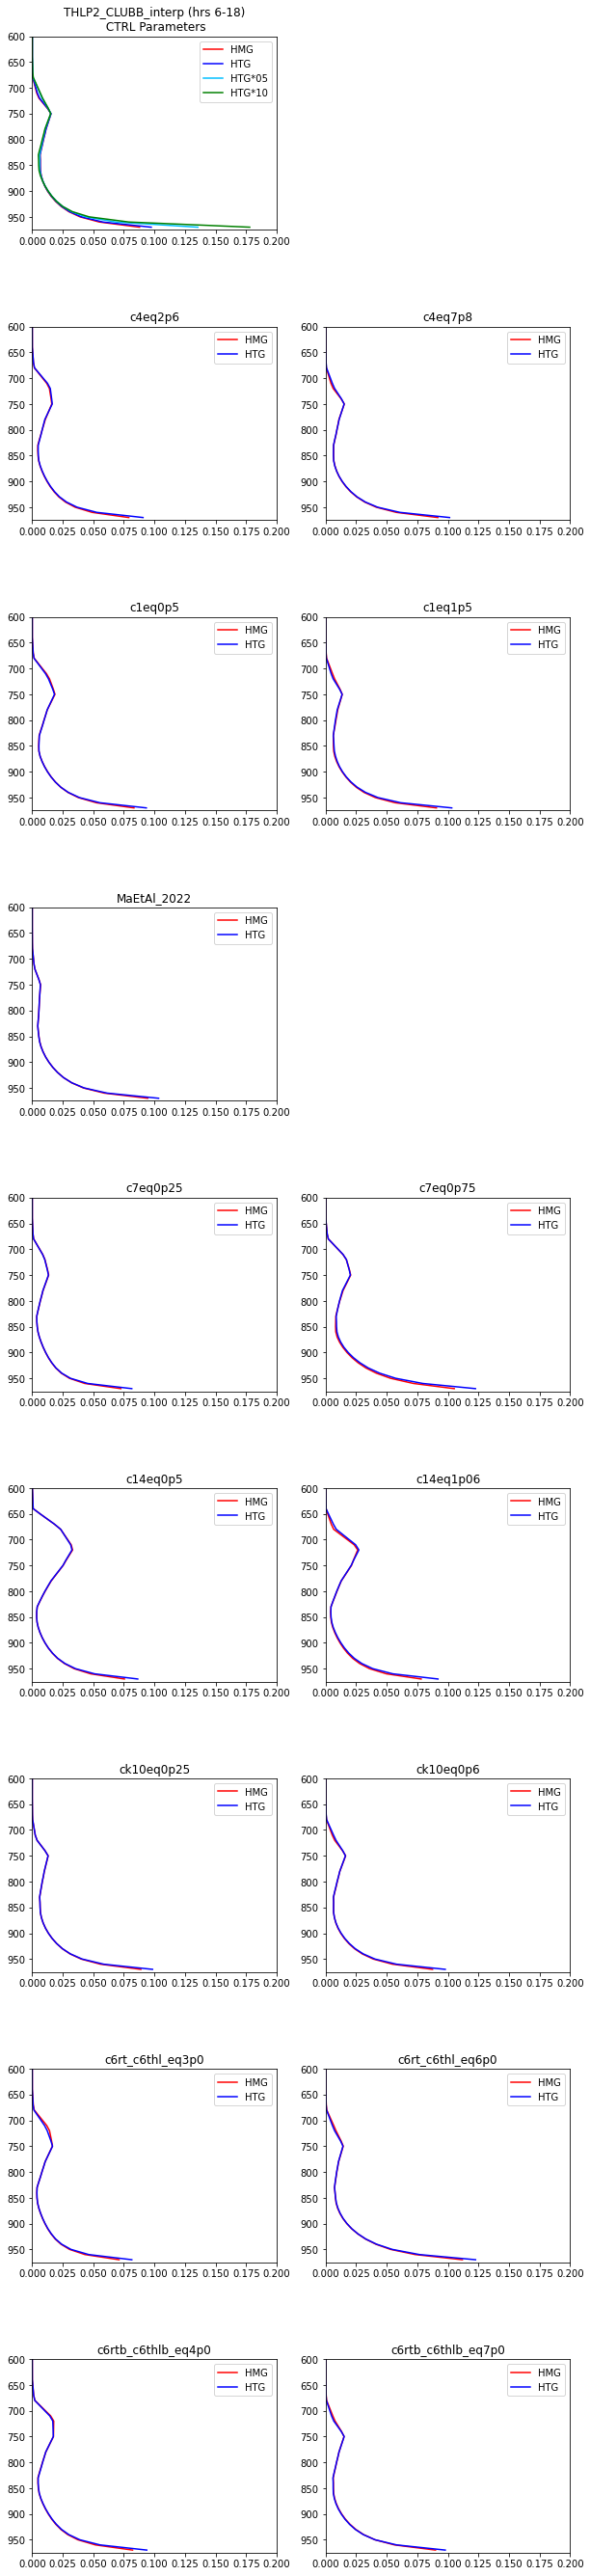

In [41]:
plot_profile('THLP2_CLUBB_interp',6,18,
                         0,0.2,
                         975,600)

